In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import io, os
import numpy as np
import matplotlib.pyplot as plt
import requests
from astropy.io import fits

# ================== CONFIG ==================
# Alvo: LHS 1140 (fotosfera ~3100 K)
TEFF_K   = 3100
LOGG_TRY = [5.00, 4.50]
FEH      = 0.0           # aparece como "-0.0" no nome
LMIN, LMAX = 0.5, 2.8    # µm para o recorte do plot

# Grade p/ plot em R constante (linhas visíveis, sem suavização)
R_PLOT   = 800.0         # amostragem alvo (↑ = mais pontos)
SAMPLES_PER_FWHM = 5     # ~amostras por FWHM ao gerar a grade log

# (Opcional) “instrumento”: convolução gaussiana com R_inst
# Coloque None para desabilitar a convolução
R_INST = 100.0           # e.g., 100 (NIRISS/SOSS R~100); ou None

# proxies do SO (se houver)
PROXIES = {k: v for k, v in {
    "http":  os.environ.get("HTTP_PROXY")  or os.environ.get("http_proxy"),
    "https": os.environ.get("HTTPS_PROXY") or os.environ.get("https_proxy"),
}.items() if v}

BASE = "https://phoenix.astro.physik.uni-goettingen.de/data/HiResFITS"
SET  = "PHOENIX-ACES-AGSS-COND-2011"

# ================== HELPERS (PHOENIX) ==================
def fmt_teff(t): return f"{int(t):05d}"
def fmt_logg(g): return f"{g:.2f}"

def feh_str(z: float) -> str:
    s = f"{z:+.1f}"
    return s.replace("+0.0", "-0.0")

def file_url(teff: int, logg: float, feh: float) -> str:
    z = feh_str(feh)              # '-0.0', '-0.5', '+0.5', ...
    fname = f"lte{fmt_teff(teff)}-{fmt_logg(logg)}{z}.{SET}-HiRes.fits"
    # pasta tem o mesmo z: Z-0.0, Z-0.5, Z+0.5, ...
    return f"{BASE}/{SET}/Z{z}/{fname}"

def get_bytes(url, timeout=60):
    r = requests.get(url, timeout=timeout, proxies=PROXIES,
                     headers={"User-Agent":"python-requests/phoenix"})
    r.raise_for_status()
    return io.BytesIO(r.content)

def read_wave_from_wavefits():
    url = f"{BASE}/WAVE_{SET}.fits"
    with fits.open(get_bytes(url), memmap=False) as hdul:
        for h in hdul:
            data = getattr(h, "data", None)
            if data is not None:
                wavA = np.array(data).ravel().astype(float)
                if wavA.size > 1000:
                    return wavA
    raise RuntimeError("WAVE_* FITS não contém grade de λ utilizável.")

def read_flux_and_wave_from_url(url):
    with fits.open(get_bytes(url), memmap=False) as hdul:
        # caso A: imagem com CRVAL1/CDELT1/CRPIX1
        if hdul[0].data is not None and hdul[0].header.get("CRVAL1") is not None:
            h = hdul[0].header
            flux = np.asarray(hdul[0].data, float).ravel()
            n    = flux.size
            crv, cd = h["CRVAL1"], h["CDELT1"]
            cp      = h.get("CRPIX1", 1.0)
            idx     = np.arange(n, dtype=float)
            wavA    = crv + (idx + 1 - cp) * cd
            return wavA, flux
        # caso B: tabela com WAVE/FLUX
        for hdu in hdul[1:]:
            if hasattr(hdu, "columns") and hdu.columns is not None:
                names = [n.upper() for n in hdu.columns.names]
                if "WAVE" in names and "FLUX" in names:
                    tab  = hdu.data
                    wavA = np.array(tab["WAVE"], float)
                    flux = np.array(tab["FLUX"], float)
                    return wavA, flux
        # caso C: usar WAVE global
        flux = np.asarray(hdul[0].data, float).ravel()
    wavA = read_wave_from_wavefits()
    n = min(wavA.size, flux.size)
    return wavA[:n], flux[:n]

def fetch_phoenix(teff, logg_list, feh):
    last_err = None
    for lg in logg_list:
        url = file_url(teff, lg, feh)
        try:
            wavA, flux = read_flux_and_wave_from_url(url)
            return wavA, flux, lg, url
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Falhou download (proxy/404?). Último erro:\n{last_err}")

# ================== R-CONSTANTE & CONVOLUÇÃO ==================
def ln_grid(lmin_um: float, lmax_um: float, dln: float) -> np.ndarray:
    n = int(np.ceil(np.log(lmax_um/lmin_um)/dln)) + 1
    return np.linspace(np.log(lmin_um), np.log(lmax_um), n)

def constR_resample(lam_um, flux, R: float, samples_per_fwhm: int = 5):
    """
    Reamostra (λ, F) em grade de ln λ com passo dln ≈ (1/R)/samples_per_fwhm.
    Retorna (lam_R, F_R) com Δλ/λ ~ 1/R (sem suavização).
    """
    lam_um = np.asarray(lam_um, float)
    flux   = np.asarray(flux, float)
    lmin, lmax = float(np.min(lam_um)), float(np.max(lam_um))
    dln = 1.0 / (R * max(1, samples_per_fwhm))
    g = ln_grid(lmin, lmax, dln)
    Fg = np.interp(np.exp(g), lam_um, flux)
    return np.exp(g), Fg

def gaussian_kernel_sigma(sigma: float, nsigma: float = 4.0):
    """
    kernel Gaussiano 1D centrado, em coordenada da grade (aqui ln λ).
    'sigma' é o desvio padrão em unidades da grade (ex.: sigma_ln).
    """
    half = int(np.ceil(nsigma * sigma))
    x = np.arange(-half, half+1, dtype=float)
    k = np.exp(-0.5*(x/sigma)**2)
    k /= k.sum()
    return k

def convolve_constR(lam_um, flux, R_inst: float, samples_per_fwhm: int = 5):
    """
    Convolui um espectro com LSF gaussiano de resolução R_inst,
    trabalhando em ln λ (onde a FWHM relativa é constante).
    """
    lam_um = np.asarray(lam_um, float)
    flux   = np.asarray(flux, float)

    # grade uniforme em ln λ para evitar variação de largura do kernel
    lmin, lmax = float(np.min(lam_um)), float(np.max(lam_um))
    dln = 1.0 / (R_inst * max(1, samples_per_fwhm))  # passo fino p/ amostrar bem o LSF
    g = ln_grid(lmin, lmax, dln)
    Fg = np.interp(np.exp(g), lam_um, flux)

    # largura gaussiana em ln λ
    FWHM_ln = 1.0 / R_inst
    sigma_ln = FWHM_ln / (2.0*np.sqrt(2.0*np.log(2.0)))  # FWHM = 2*sqrt(2ln2)*sigma

    # sigma em unidades de "bins" da grade g
    sigma_bins = sigma_ln / dln
    ker = gaussian_kernel_sigma(sigma_bins, nsigma=4.0)

    F_conv = np.convolve(Fg, ker, mode='same')
    return np.exp(g), F_conv

# ================== MAIN ==================
def main():
    # 1) baixa PHOENIX
    wavA, flux, used_logg, used_url = fetch_phoenix(TEFF_K, LOGG_TRY, FEH)
    lam_um = wavA * 1e-4
    m = np.isfinite(lam_um) & np.isfinite(flux) & (lam_um >= LMIN) & (lam_um <= LMAX)
    lam_um, flux = lam_um[m], flux[m]

    # 2) normalização só para visual (pseudo-contínuo ~1)
    ref = (lam_um > 1.0) & (lam_um < 1.8)
    scale = np.nanmedian(flux[ref]) if np.any(ref) else np.nanmedian(flux)
    y = flux / scale

    print(f"[OK] {used_url}")

    # 3) grade de R constante (linhas visíveis, sem suavizar)
    lam_R, y_R = constR_resample(lam_um, y, R=R_PLOT, samples_per_fwhm=SAMPLES_PER_FWHM)

    # 4) convolução opcional com LSF gaussiano (R_inst)
    if R_INST is not None:
        lam_conv, y_conv = convolve_constR(lam_um, y, R_inst=R_INST, samples_per_fwhm=max(5, SAMPLES_PER_FWHM))
        # Reamostra a versão convoluída na MESMA grade de plot (opcional, só p/ sobrepor bonitinho)
        y_conv_plot = np.interp(lam_R, lam_conv, y_conv)
    else:
        y_conv_plot = None

    # 5) plot
    plt.figure(figsize=(9.2, 4.8))
    # linhas “cruas” (R constante, sem suavização) — só ligar pontos
    plt.plot(lam_R, y_R, '-', lw=1.0, label=f"PHOENIX (amostrado, R≈{int(R_PLOT)})")
    plt.plot(lam_R, y_R, '', ms=2.0, alpha=0.6)

    # versão “observada” (convoluída)
    if y_conv_plot is not None:
        plt.plot(lam_R, y_conv_plot, '-', lw=2.0, label=f"PHOENIX ⊗ LSF (R≈{int(R_INST)})", alpha=0.9)

    plt.xlabel("Wavelength (µm)")
    plt.ylabel("Normalized $F_\\lambda$ (PHOENIX)")
    ttl = f"LHS 1140 — Teff={TEFF_K} K, log g={used_logg:.2f}, [M/H]={FEH:+.1f}"
    plt.title(ttl)
    plt.xlim(LMIN, LMAX)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


[THR] CSV='niriss_soss_thr_combined_switch.csv'  λ=0.600–2.800 µm; thr=[0.097,1.000]
[THR] using throughput
[DATA] Loaded 28 points from NIRISS_R_20.csv
[PHOENIX] warmed cache for 3 T's on 28 λ.


100%|██████████| 4500/4500 [23:14<00:00,  3.23it/s]   



[POSTERIOR SUMMARY]
  f_spot        : 0.05948  (-0.05001/+0.13484)
  f_fac         : 0.15510  (-0.05691/+0.10141)
  T_spot [K]    : 2966.9  (-193.2/+57.7)
  T_fac  [K]    : 3202.0  (-35.6/+36.0)
  jitter [ppm]  : 14.3  (-6.4/+6.7)
  s (escala)    : 0.9941  (-0.0032/+0.0029)

[MEDIAN PARAMS (saved)]
  f_spot=0.05948, f_fac=0.15510, T_spot=3000.0 K, T_fac=3200.0 K, s=0.9941
[PHOENIX] warmed cache for 3 T's on 450 λ.
[INFO] covariância (densidade R≈50) salva em 'stack_covariances_tls.npz'  (N=450)


C:\Users\vikto\AppData\Local\Temp\ipykernel_25892\944532648.py:721: UserWarning: Glyph 181 (\N{MICRO SIGN}) missing from font(s) Neutraface 2 Display.
  plt.legend(); plt.tight_layout(); plt.show()
C:\Users\vikto\AppData\Local\Temp\ipykernel_25892\944532648.py:721: UserWarning: Glyph 916 (\N{GREEK CAPITAL LETTER DELTA}) missing from font(s) Neutraface 2 Display.
  plt.legend(); plt.tight_layout(); plt.show()
C:\Users\vikto\AppData\Local\Temp\ipykernel_25892\944532648.py:721: UserWarning: Glyph 963 (\N{GREEK SMALL LETTER SIGMA}) missing from font(s) Neutraface 2 Display.
  plt.legend(); plt.tight_layout(); plt.show()
c:\Users\vikto\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 916 (\N{GREEK CAPITAL LETTER DELTA}) missing from font(s) Neutraface 2 Display.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vikto\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 963 (\N{GREEK SMALL LETTER SIGMA}) missing from font(s) Neutraface

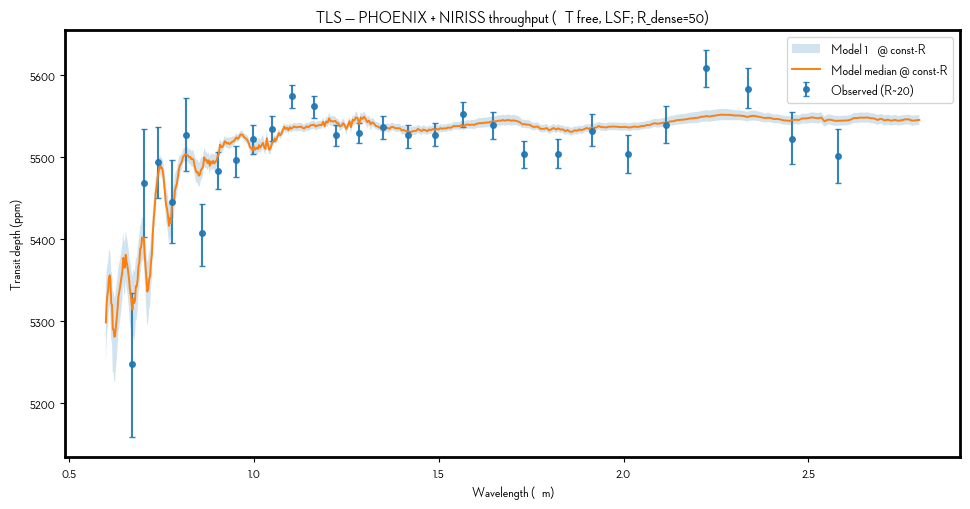

C:\Users\vikto\AppData\Local\Temp\ipykernel_25892\944532648.py:569: UserWarning: Glyph 181 (\N{MICRO SIGN}) missing from font(s) Neutraface 2 Display.
  plt.legend(); plt.tight_layout(); plt.show()
C:\Users\vikto\AppData\Local\Temp\ipykernel_25892\944532648.py:569: UserWarning: Glyph 963 (\N{GREEK SMALL LETTER SIGMA}) missing from font(s) Neutraface 2 Display.
  plt.legend(); plt.tight_layout(); plt.show()


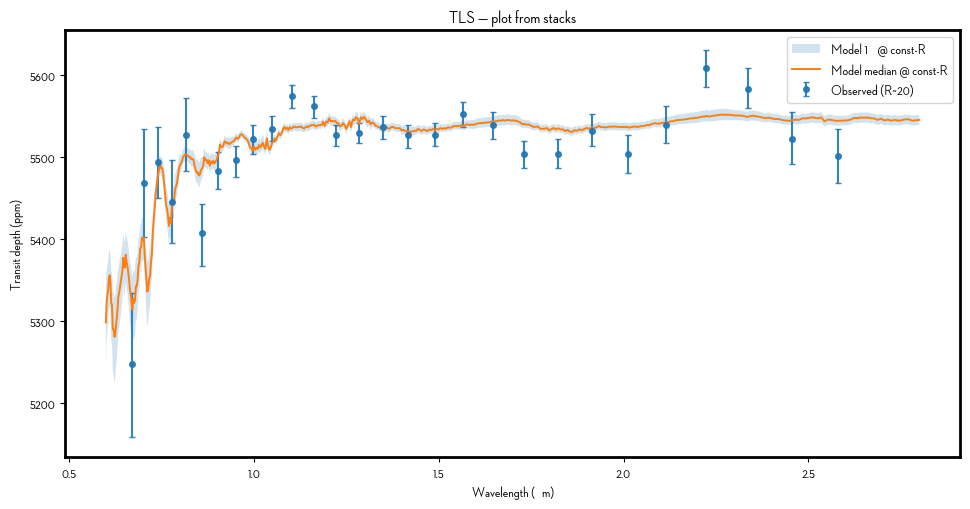

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
TLS – Stellar contamination (spots + faculae) com SED PHOENIX,
LSF por canal (dx_low+dx_high) + fallback R-constante, ΔT livre (clipped),
throughput NIRISS/SOSS, escala global s (explícita ou marginalizada),
stacks, posterior em disco e replot/rebuild sem re-rodar o MCMC.

Requisitos:
  pip install numpy matplotlib requests astropy emcee
"""

from __future__ import annotations
import os, io, csv
from typing import Sequence, Tuple, List, Optional, Dict

import numpy as np
import matplotlib.pyplot as plt
import requests
from astropy.io import fits
import emcee

# =========================== CONFIG ===========================================
RUN_MODE = "full"   # "full" | "rebuild_dense" | "plot_only"
MODEL_MODE = "both"          # 'both' | 'spots' | 'faculae'

USE_SPLIT_NORMAL = True      # True: split-normal (s explícito) | False: Gauss (s marginal)
PHOENIX_ONLY = True
DELTA_T_MODE  = "free"       # "free" | "fixed"
DELTA_T_K     = 1000.0       # se fixed

# Sistema (ajuste ao seu alvo)
Rp_Rearth = 1.73
Rs_Rsun   = 0.2112
T_phot    = 3096.0

# Arquivos
OBS_CSV  = "NIRISS_R_20.csv"                         # λ[µm], depth[ppm], dy_low, dy_high, dx_low, dx_high
SENS_CSV = "niriss_soss_thr_combined_switch.csv"     # <<< CSV Pandeia “switch”

# LSF / rebin
R_FALLBACK       = 20.0     # se não houver dx no CSV
NSUB_OBS         = 121      # subamostras por canal no fit
R_DENSE          = 50.0     # R da curva densa (mude p/ 80–120 p/ ver mais estrutura)
USE_THR_IN_DENSE = False    # evitar “dobrar” throughput na curva densa

# Curva densa (domínio)
LMIN_PLOT = 0.60
LMAX_PLOT = 2.80
N_CONST_R = 450
NSUB_DENSE = 301

# Stacks
STACK_DATA   = "stack_data_R-TLSE.txt"
STACK_MODELS = "stack_models_R-TLSE.txt"
STACK_PARAMS = "stack_params_R-TLSE.txt"
STACK_POST   = "stack_post_R-TLSE.txt"    # amostras da posterior (para rebuild)
NSAVE_POST   = 400
DATASET_TAG  = "R20"
METHOD_TAG   = "TLS-PHX-SOSS"
METHOD_FULL  = METHOD_TAG + " @constR"
OVERWRITE_STACKS = True

# MCMC
N_WALKERS = 72
N_STEPS   = 4500
BURNIN    = 1700
THIN      = 10
RNG_SEED  = 42

# =========================== Constantes =======================================
R_EARTH = 6.371e6; R_SUN = 6.9634e8
T_MIN_PHX = 2300.0; T_MAX_PHX = 7000.0
_FWHM_TO_SIGMA = 1.0 / 2.354820045

# =========================== PHOENIX (cache + IO) =============================
PROXIES = {k: v for k, v in {
    "http":  os.environ.get("HTTP_PROXY")  or os.environ.get("http_proxy"),
    "https": os.environ.get("HTTPS_PROXY") or os.environ.get("https_proxy"),
}.items() if v}

BASE = "https://phoenix.astro.physik.uni-goettingen.de/data/HiResFITS"
SET  = "PHOENIX-ACES-AGSS-COND-2011"
LOGG_TRY = [5.00, 4.50]

def _feh_str(z: float) -> str:
    s = f"{z:+.1f}"
    return s.replace("+0.0", "-0.0")

def _phoenix_url(teff: int, logg: float, feh: float) -> str:
    z = _feh_str(feh); fname = f"lte{int(teff):05d}-{logg:.2f}{z}.{SET}-HiRes.fits"
    return f"{BASE}/{SET}/Z{z}/{fname}"

def _get_bytes(url: str, timeout=120) -> io.BytesIO:
    r = requests.get(url, timeout=timeout, proxies=PROXIES,
                     headers={"User-Agent":"python-requests/phoenix"}, allow_redirects=True)
    r.raise_for_status(); return io.BytesIO(r.content)

def _read_wave_from_wavefits() -> np.ndarray:
    url = f"{BASE}/WAVE_{SET}.fits"
    with fits.open(_get_bytes(url), memmap=False) as hdul:
        for h in hdul:
            if getattr(h, "data", None) is not None:
                w = np.array(h.data).ravel().astype(float)
                if w.size > 1000: return w
    raise RuntimeError("WAVE_* FITS missing wavelength grid.")

def _read_flux_and_wave_from_url(url: str) -> Tuple[np.ndarray, np.ndarray]:
    with fits.open(_get_bytes(url), memmap=False) as hdul:
        if hdul[0].data is not None and hdul[0].header.get("CRVAL1") is not None:
            h = hdul[0].header; flux = np.asarray(hdul[0].data, float).ravel(); n = flux.size
            crv, cd = h["CRVAL1"], h["CDELT1"]; cp = h.get("CRPIX1", 1.0)
            idx = np.arange(n, dtype=float); wavA = crv + (idx + 1 - cp) * cd
            return wavA, flux
        for hdu in hdul[1:]:
            if hasattr(hdu, "columns") and hdu.columns is not None:
                names = [n.upper() for n in hdu.columns.names]
                if "WAVE" in names and "FLUX" in names:
                    tab = hdu.data; return np.array(tab["WAVE"], float), np.array(tab["FLUX"], float)
        flux = np.asarray(hdul[0].data, float).ravel()
    wavA = _read_wave_from_wavefits(); n = min(wavA.size, flux.size)
    return wavA[:n], flux[:n]

_PHX_CACHE: Dict[Tuple[int, float], Tuple[np.ndarray, np.ndarray]] = {}
_PHX_INTERP_CACHE: Dict[Tuple[Tuple[float, ...], int, float], np.ndarray] = {}
_PHX_MISSING: set[Tuple[int, float]] = set()

def _clip_T_to_phx_grid(T: float) -> float:
    Tgrid = int(round(T/100.0)*100); return float(np.clip(Tgrid, T_MIN_PHX, T_MAX_PHX))

def phoenix_flux_interp(lam_um_target: np.ndarray, T: float, feh: float = 0.0) -> np.ndarray:
    lam_target = np.asarray(lam_um_target, float); lam_key = tuple(lam_target)
    Tgrid = int(np.round(_clip_T_to_phx_grid(T)/100.0)*100)
    if all((Tgrid, lg) in _PHX_MISSING for lg in LOGG_TRY):
        raise RuntimeError(f"No PHOENIX file for Teff≈{Tgrid} K.")
    for lg in LOGG_TRY:
        key_interp = (lam_key, Tgrid, lg)
        if key_interp in _PHX_INTERP_CACHE: return _PHX_INTERP_CACHE[key_interp]
        base_key = (Tgrid, lg)
        if base_key not in _PHX_CACHE:
            wavA, flux = _read_flux_and_wave_from_url(_phoenix_url(Tgrid, lg, feh))
            _PHX_CACHE[base_key] = (wavA * 1e-4, flux)  # Å → µm
        lam_model_um, flux = _PHX_CACHE[base_key]
        m = np.isfinite(lam_model_um) & np.isfinite(flux)
        if np.count_nonzero(m) < 10:
            _PHX_MISSING.add((Tgrid, lg)); continue
        f_interp = np.interp(lam_target, lam_model_um[m], flux[m], left=np.nan, right=np.nan)
        _PHX_INTERP_CACHE[key_interp] = f_interp; return f_interp
    for lg in LOGG_TRY: _PHX_MISSING.add((Tgrid, lg))
    raise RuntimeError(f"No PHOENIX file for Teff≈{Tgrid} K.")

def warm_phoenix_cache(lam_um_target: np.ndarray, T_list: Sequence[float], feh: float = 0.0):
    ok = 0
    for T in sorted(set(int(round(_clip_T_to_phx_grid(T)/100)*100) for T in T_list)):
        try: _ = phoenix_flux_interp(lam_um_target, T, feh=feh); ok += 1
        except Exception: pass
    print(f"[PHOENIX] warmed cache for {ok} T's on {len(lam_um_target)} λ.")

# =========================== Throughput =======================================
def load_throughput_csv(path: str) -> Optional[Tuple[np.ndarray, np.ndarray]]:
    """Parser tolerante: header/CSV, vírgulas ou espaços, detecta unidades e normaliza [0,1]."""
    if not os.path.exists(path):
        return None
    xs, ys = [], []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            s = line.strip()
            if not s or s.startswith("#"):
                continue
            parts = s.replace(",", " ").split()
            if len(parts) < 2:
                continue
            try:
                x = float(parts[0]); y = float(parts[1])
            except Exception:
                continue
            xs.append(x); ys.append(y)

    if not xs:
        return None

    wl = np.asarray(xs, float)
    th = np.asarray(ys, float)

    # Unidades → µm
    mx = float(np.nanmax(np.abs(wl)))
    if mx > 3000.0:      # Å
        lam_um = wl / 1e4
    elif mx > 40.0:      # nm
        lam_um = wl / 1e3
    else:                # µm
        lam_um = wl

    # Normalização
    if float(np.nanmax(np.abs(th))) > 1.5:
        th = th / 100.0
    th = np.clip(th, 0.0, 1.0)

    order = np.argsort(lam_um)
    lam_um = lam_um[order]
    th     = th[order]

    print(f"[THR] CSV='{os.path.basename(path)}'  λ={lam_um.min():.3f}–{lam_um.max():.3f} µm; thr=[{th.min():.3f},{th.max():.3f}]")
    return lam_um, th

THR = load_throughput_csv(SENS_CSV)
print("[THR] using throughput" if THR is not None else "[THR] no throughput file found")

def throughput_at(lam_um: np.ndarray) -> np.ndarray:
    if THR is None: return np.ones_like(lam_um, float)
    lam_t, thr_t = THR
    return np.interp(lam_um, lam_t, thr_t, left=0.0, right=0.0)

# =========================== LSF helpers ======================================
def _lsf_sigma(center_um: float,
               dx_low_um: Optional[float],
               dx_high_um: Optional[float],
               R_fallback: float) -> float:
    have_dx = (dx_low_um is not None and dx_high_um is not None
               and np.isfinite(dx_low_um) and np.isfinite(dx_high_um)
               and (dx_low_um > 0 or dx_high_um > 0))
    FWHM = abs(dx_low_um) + abs(dx_high_um) if have_dx else center_um / R_fallback
    return max(FWHM * _FWHM_TO_SIGMA, 0.0)

# =========================== Modelo TLS =======================================
def transit_depth_true(Rp_Rearth: float, Rs_Rsun: float) -> float:
    return (Rp_Rearth*R_EARTH / (Rs_Rsun*R_SUN))**2

def sed_flux_phx(lam_um: np.ndarray, T: float) -> np.ndarray:
    return phoenix_flux_interp(lam_um, _clip_T_to_phx_grid(T))

def epsilon_spot_fac(lam_um, f_spot, f_fac, T_spot, T_fac, T_phot):
    lam_um = np.asarray(lam_um, float)
    Sph = sed_flux_phx(lam_um, T_phot)
    Ssp = sed_flux_phx(lam_um, T_spot)
    Sfa = sed_flux_phx(lam_um, T_fac)
    m = np.isfinite(Sph) & np.isfinite(Ssp) & np.isfinite(Sfa)
    out = np.full_like(lam_um, np.nan, float)
    if np.any(m):
        out[m] = 1.0 / (1.0 - f_spot*(1.0 - Ssp[m]/Sph[m]) - f_fac*(1.0 - Sfa[m]/Sph[m]))
    return out

def model_depth_ppm(lam_um, Rp_Rearth, Rs_Rsun, f_spot, f_fac, T_spot, T_fac, T_phot, s_scale=1.0):
    Dtrue = transit_depth_true(Rp_Rearth, Rs_Rsun)
    eps   = epsilon_spot_fac(lam_um, f_spot, f_fac, T_spot, T_fac, T_phot)
    return s_scale * (Dtrue*eps)*1e6

def band_averaged_depth(center_um: float,
                        dx_low_um: Optional[float],
                        dx_high_um: Optional[float],
                        R_fallback: float,
                        nsub: int,
                        params: Tuple[float, float, float, float],
                        s_scale: float = 1.0) -> float:
    f_spot, f_fac, T_spot, T_fac = params
    sigma = _lsf_sigma(center_um, dx_low_um, dx_high_um, R_fallback)
    if not np.isfinite(sigma) or sigma <= 0: return np.nan
    lam_lo, lam_hi = center_um - 5.0*sigma, center_um + 5.0*sigma
    lam_sub = np.linspace(lam_lo, lam_hi, max(16, nsub))
    w = throughput_at(lam_sub) * np.exp(-0.5*((lam_sub-center_um)/sigma)**2)
    m = model_depth_ppm(lam_sub, Rp_Rearth, Rs_Rsun, f_spot, f_fac, T_spot, T_fac, T_phot, s_scale=s_scale)
    good = np.isfinite(m) & (w > 0)
    if not np.any(good): return np.nan
    return np.nansum(m[good]*w[good]) / np.nansum(w[good])

# =========================== Dados ============================================
def load_niriss_csv(local_path: str):
    lam, y, dyl, dyh, dxl, dxh = [], [], [], [], [], []
    with open(local_path, "r", encoding="utf-8", newline="") as f:
        rdr = csv.reader(f)
        for row in rdr:
            if (not row) or all((str(c).strip()=="") for c in row): continue
            try:
                lam_i = float(row[0]); y_i = float(row[1])
                dyl_i = float(row[2]);   dyh_i = float(row[3])
                dxl_i = float(row[4]) if len(row)>4 and row[4].strip()!="" else np.nan
                dxh_i = float(row[5]) if len(row)>5 and row[5].strip()!="" else np.nan
            except Exception:
                continue
            lam.append(lam_i); y.append(y_i); dyl.append(dyl_i); dyh.append(dyh_i)
            dxl.append(dxl_i); dxh.append(dxh_i)
    lam = np.asarray(lam, float); y = np.asarray(y, float)
    dyl = np.asarray(dyl, float); dyh = np.asarray(dyh, float)
    dxl = np.asarray(dxl, float); dxh = np.asarray(dxh, float)
    m = np.isfinite(lam) & np.isfinite(y) & np.isfinite(dyl) & np.isfinite(dyh)
    if not np.any(m): raise RuntimeError("No valid numeric rows found.")
    idx = np.argsort(lam[m])
    return lam[m][idx], y[m][idx], dyl[m][idx], dyh[m][idx], dxl[m][idx], dxh[m][idx]

# =========================== Priors / likelihood ==============================
class FitConfig:
    f_spot_bounds = (0.0, 0.6)
    f_fac_bounds  = (0.0, 0.6)
    enforce_contrast = True
    contrast_margin_K = 30.0
    ln_jitter_bounds = (np.log(1.0), np.log(800.0))  # ppm
    # bordas suaves p/ não colar no grid:
    soft_edge_spot_K = 50.0
    soft_edge_fac_K  = 50.0
    ln_s_sigma = 0.05         # prior N(0, σ) em ln(s), quando s explícito

CFG = FitConfig()

def labels_for_mode(mode: str) -> List[str]:
    base = []
    if DELTA_T_MODE == "fixed":
        base = ["f_spot","f_fac"] if mode=="both" else (["f_spot"] if mode=="spots" else ["f_fac"])
    else:
        if mode=="both": base = ["f_spot","f_fac","T_spot","T_fac"]
        elif mode=="spots": base = ["f_spot","T_spot"]
        else: base = ["f_fac","T_fac"]
    return base + (["ln_jitter_ppm","ln_s_scale"] if USE_SPLIT_NORMAL else ["ln_jitter_ppm"])

def initial_theta(mode: str, T_phot: float) -> List[float]:
    base = []
    if DELTA_T_MODE == "fixed":
        base = [0.05,0.05] if mode=="both" else [0.05]
    else:
        if mode=="both": base = [0.05,0.05, T_phot-300.0, T_phot+150.0]
        elif mode=="spots": base = [0.05, T_phot-300.0]
        else: base = [0.05, T_phot+150.0]
    base += [np.log(60.0)]
    if USE_SPLIT_NORMAL: base += [np.log(1.0)]
    return base

def unpack_theta(theta: Sequence[float], mode: str, T_phot: float):
    i = 0
    if DELTA_T_MODE == "fixed":
        if mode=="both": f_spot, f_fac = theta[i:i+2]; i+=2
        elif mode=="spots": f_spot = theta[i]; i+=1; f_fac=0.0
        else: f_fac = theta[i]; i+=1; f_spot=0.0
        T_spot = _clip_T_to_phx_grid(T_phot - DELTA_T_K)
        T_fac  = _clip_T_to_phx_grid(T_phot + DELTA_T_K)
    else:
        if mode=="both": f_spot, f_fac, T_spot, T_fac = theta[i:i+4]; i+=4
        elif mode=="spots": f_spot, T_spot = theta[i:i+2]; i+=2; f_fac=0.0; T_fac=_clip_T_to_phx_grid(T_phot+CFG.contrast_margin_K)
        else: f_fac, T_fac = theta[i:i+2]; i+=2; f_spot=0.0; T_spot=_clip_T_to_phx_grid(T_phot-CFG.contrast_margin_K)
        T_spot = _clip_T_to_phx_grid(T_spot); T_fac = _clip_T_to_phx_grid(T_fac)
    ln_jit = theta[i]; i+=1
    ln_s = theta[i] if USE_SPLIT_NORMAL else 0.0
    return float(f_spot), float(f_fac), float(T_spot), float(T_fac), float(ln_jit), float(ln_s)

def log_prior(theta, T_phot: float, mode: str) -> float:
    f_spot, f_fac, T_spot, T_fac, ln_jit, ln_s = unpack_theta(theta, mode, T_phot)
    if not (CFG.f_spot_bounds[0] <= f_spot <= CFG.f_spot_bounds[1]): return -np.inf
    if not (CFG.f_fac_bounds[0]  <= f_fac  <= CFG.f_fac_bounds[1]):  return -np.inf
    if not (CFG.ln_jitter_bounds[0] <= ln_jit <= CFG.ln_jitter_bounds[1]): return -np.inf
    # contraste físico
    if CFG.enforce_contrast:
        if f_spot > 1e-8 and not (T_spot <= T_phot - CFG.contrast_margin_K): return -np.inf
        if f_fac  > 1e-8 and not (T_fac  >= T_phot + CFG.contrast_margin_K): return -np.inf
    # bordas suaves
    lp = 0.0
    if T_spot < T_MIN_PHX + CFG.soft_edge_spot_K:
        d = (T_MIN_PHX + CFG.soft_edge_spot_K - T_spot)/CFG.soft_edge_spot_K
        lp -= 0.5*(5.0*d)**2
    if T_fac > T_MAX_PHX - CFG.soft_edge_fac_K:
        d = (T_fac - (T_MAX_PHX - CFG.soft_edge_fac_K))/CFG.soft_edge_fac_K
        lp -= 0.5*(5.0*d)**2
    # prior fraco em s (quando explícito): ln s ~ N(0, σ^2)
    if USE_SPLIT_NORMAL:
        lp -= 0.5*(ln_s/CFG.ln_s_sigma)**2 + np.log(CFG.ln_s_sigma*np.sqrt(2*np.pi))
    return lp

# ---------- Likelihood ----------
def _sym_sigma(dy_low_ppm, dy_high_ppm): return 0.5*(np.asarray(dy_low_ppm,float)+np.asarray(dy_high_ppm,float))

def _loglike_gaussian_with_marginal_s(y_obs, y_mod, sig_obs, ln_jit):
    jit = np.exp(ln_jit); var = sig_obs**2 + jit**2; w = 1.0/var
    M1 = np.sum(w*(y_mod**2)); M2 = np.sum(w*(y_obs*y_mod)); M0 = np.sum(w*(y_obs**2))
    if M1 <= 0: return -np.inf
    chi2 = M0 - (M2**2)/M1
    return -0.5*(chi2 + np.sum(np.log(2*np.pi*var)))

def _loglike_splitnormal_with_s(y_obs, y_mod, dy_low, dy_high, ln_jit, ln_s):
    s = np.exp(ln_s); jit = np.exp(ln_jit)
    r = y_obs - s*y_mod
    sig_side = np.where(r >= 0.0, dy_high, dy_low)
    var = sig_side**2 + jit**2
    return -0.5*np.sum((r**2)/var + np.log(2*np.pi*var))

def log_likelihood(theta, lam, D_obs_ppm, dy_low, dy_high, dx_low, dx_high,
                   Rp_Rearth, Rs_Rsun, T_phot, mode: str):
    f_spot, f_fac, T_spot, T_fac, ln_jit, ln_s = unpack_theta(theta, mode, T_phot)
    y_mod = np.array([band_averaged_depth(lc, dl, dh, R_FALLBACK, NSUB_OBS,
                                          (f_spot, f_fac, T_spot, T_fac), s_scale=1.0)
                      for lc, dl, dh in zip(lam, dx_low, dx_high)], float)
    if not np.all(np.isfinite(y_mod)): return -np.inf
    if USE_SPLIT_NORMAL:
        return _loglike_splitnormal_with_s(D_obs_ppm, y_mod, dy_low, dy_high, ln_jit, ln_s)
    else:
        sig = _sym_sigma(dy_low, dy_high)
        return _loglike_gaussian_with_marginal_s(D_obs_ppm, y_mod, sig, ln_jit)

def log_posterior(theta, lam, D_obs_ppm, dy_low, dy_high, dx_low, dx_high,
                  Rp_Rearth, Rs_Rsun, T_phot, mode: str):
    lp = log_prior(theta, T_phot, mode)
    if not np.isfinite(lp): return -np.inf
    ll = log_likelihood(theta, lam, D_obs_ppm, dy_low, dy_high, dx_low, dx_high,
                        Rp_Rearth, Rs_Rsun, T_phot, mode)
    return lp + ll

# =========================== MCMC =============================================
def run_mcmc(lam, D_obs_ppm, dy_low, dy_high, dx_low, dx_high,
             Rp_Rearth, Rs_Rsun, T_phot,
             mode: str = MODEL_MODE,
             nwalkers=N_WALKERS, nsteps=N_STEPS, burnin=BURNIN, thin=THIN, seed=RNG_SEED):
    rng = np.random.default_rng(seed)
    theta0 = initial_theta(mode, T_phot); labels = labels_for_mode(mode); ndim = len(theta0)
    pos = theta0 + 1e-3 * rng.standard_normal((nwalkers, ndim))
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_posterior,
        args=(lam, D_obs_ppm, dy_low, dy_high, dx_low, dx_high,
              Rp_Rearth, Rs_Rsun, T_phot, mode)
    )
    sampler.run_mcmc(pos, nsteps, progress=True)
    flat      = sampler.get_chain(discard=burnin, thin=thin, flat=True)
    flat_logp = sampler.get_log_prob(discard=burnin, thin=thin, flat=True)
    return flat, flat_logp, labels

def theta_map_from_flat(flat, flat_logp): return flat[int(np.argmax(flat_logp))]

# =========================== Curva densa (const-R) ============================
def sample_constant_R(lmin: float, lmax: float, n: int) -> np.ndarray:
    if n < 2: return np.array([lmin, lmax], float)
    r = (lmax/lmin)**(1/(n-1)); return lmin * (r ** np.arange(n))

def lsf_average_curve(lam_eval: np.ndarray, R_eff: float, params: Tuple[float,float,float,float],
                      s_scale: float, nsub: int = NSUB_DENSE, use_thr: bool = USE_THR_IN_DENSE) -> np.ndarray:
    f_spot, f_fac, T_spot, T_fac = params
    out = np.empty_like(lam_eval, float)
    for i, lc in enumerate(lam_eval):
        sigma = (lc / R_eff) * _FWHM_TO_SIGMA
        lam = np.linspace(lc-5*sigma, lc+5*sigma, nsub)
        w = np.exp(-0.5*((lam-lc)/sigma)**2)
        if use_thr: w *= throughput_at(lam)
        m = model_depth_ppm(lam, Rp_Rearth, Rs_Rsun, f_spot, f_fac, T_spot, T_fac, T_phot, s_scale=s_scale)
        good = np.isfinite(m) & (w > 0)
        out[i] = np.nan if not np.any(good) else (np.nansum(m[good]*w[good]) / np.nansum(w[good]))
    return out

# =========================== Stacks (IO) ======================================
def write_stack_files(lam_obs, D_obs_ppm, dy_low, dy_high,
                      lam_dense, med_den, lo_den, hi_den,
                      labels, med_params,
                      txt_data=STACK_DATA, txt_models=STACK_MODELS, txt_params=STACK_PARAMS):
    mode = "w" if OVERWRITE_STACKS else "a"

    new_data = (not os.path.exists(txt_data)) or OVERWRITE_STACKS
    with open(txt_data, mode, newline="", encoding="utf-8") as f:
        w = csv.writer(f, delimiter="\t")
        if new_data: w.writerow(["dataset","lambda_um","depth_ppm","dy_low","dy_high"])
        for x,y,lo,hi in zip(lam_obs, D_obs_ppm, dy_low, dy_high):
            w.writerow([DATASET_TAG, f"{x:.9g}", f"{y:.9g}", f"{lo:.9g}", f"{hi:.9g}"])

    new_models = (not os.path.exists(txt_models)) or OVERWRITE_STACKS
    with open(txt_models, mode, newline="", encoding="utf-8") as f:
        w = csv.writer(f, delimiter="\t")
        if new_models: w.writerow(["dataset","method","lambda_um","median_ppm","lo_ppm","hi_ppm"])
        for x,m,lo,hi in zip(lam_dense, med_den, lo_den, hi_den):
            w.writerow([DATASET_TAG, METHOD_FULL, f"{x:.9g}", f"{m:.9g}", f"{lo:.9g}", f"{hi:.9g}"])

    new_params = (not os.path.exists(txt_params)) or OVERWRITE_STACKS
    with open(txt_params, mode, newline="", encoding="utf-8") as f:
        w = csv.writer(f, delimiter="\t")
        if new_params: w.writerow(["dataset","method"] + labels)
        w.writerow([DATASET_TAG, METHOD_FULL] + [f"{p:.9g}" for p in med_params])

def save_posterior_samples(flat, labels, path=STACK_POST):
    new = not os.path.exists(path)
    with open(path, "a", newline="", encoding="utf-8") as f:
        w = csv.writer(f, delimiter="\t")
        if new: w.writerow(["dataset","method"] + labels)
        for row in flat:
            w.writerow([DATASET_TAG, METHOD_FULL] + [f"{v:.9g}" for v in row])

def _read_stack_data(path, dataset):
    xs, ys, lo, hi = [], [], [], []
    with open(path, "r", encoding="utf-8") as f:
        rdr = csv.reader(f, delimiter="\t"); _ = next(rdr, None)
        for row in rdr:
            if not row or len(row) < 5: continue
            if row[0] != dataset: continue
            xs.append(float(row[1])); ys.append(float(row[2]))
            lo.append(float(row[3])); hi.append(float(row[4]))
    xs = np.asarray(xs); ys = np.asarray(ys); lo = np.asarray(lo); hi = np.asarray(hi)
    idx = np.argsort(xs); return xs[idx], ys[idx], lo[idx], hi[idx]

def _read_stack_model_exact(path, dataset, method_exact):
    xs, med, lo, hi = [], [], [], []
    with open(path, "r", encoding="utf-8") as f:
        rdr = csv.reader(f, delimiter="\t"); _ = next(rdr, None)
        for row in rdr:
            if not row or len(row) < 6: continue
            if row[0] != dataset or row[1] != method_exact: continue
            xs.append(float(row[2])); med.append(float(row[3]))
            lo.append(float(row[4])); hi.append(float(row[5]))
    xs = np.asarray(xs); med = np.asarray(med); lo = np.asarray(lo); hi = np.asarray(hi)
    order = np.argsort(xs); xs, med, lo, hi = xs[order], med[order], lo[order], hi[order]
    # colapsar duplicadas (se houver)
    uniq_x, mm, ll, hh = [], [], [], []
    i = 0; tol = 1e-12
    while i < xs.size:
        j = i+1
        while j < xs.size and abs(xs[j]-xs[i]) <= tol: j += 1
        uniq_x.append(xs[i]); mm.append(np.median(med[i:j])); ll.append(np.median(lo[i:j])); hh.append(np.median(hi[i:j]))
        i = j
    return np.asarray(uniq_x), np.asarray(mm), np.asarray(ll), np.asarray(hh)

def _read_post_samples(path, dataset, method):
    if not os.path.exists(path): return None, None
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        rdr = csv.reader(f, delimiter="\t"); hdr = next(rdr, None)
        labels = hdr[2:]
        for r in rdr:
            if r and r[0]==dataset and r[1]==method:
                try:
                    rows.append(list(map(float, r[2:])))
                except Exception:
                    pass
    if not rows: return None, None
    return np.asarray(rows, float), labels

# =========================== Relatórios / Plot ================================
def print_param_summary_from_samples(samples: np.ndarray, labels: List[str]):
    """Imprime medianas e [16,84]% se houver amostras; converte ln_s para s."""
    name_map = {"f_spot":"f_spot", "f_fac":"f_fac",
                "T_spot":"T_spot [K]", "T_fac":"T_fac [K]",
                "ln_jitter_ppm":"jitter [ppm]", "ln_s_scale":"s"}
    idx = {lab:i for i,lab in enumerate(labels)}
    def pct(arr):
        p16, p50, p84 = np.percentile(arr, [16,50,84])
        return p16, p50, p84

    print("\n[POSTERIOR SUMMARY]")
    if "f_spot" in idx:
        a = samples[:, idx["f_spot"]]; p16,p50,p84 = pct(a)
        print(f"  f_spot        : {p50:.5f}  (-{p50-p16:.5f}/+{p84-p50:.5f})")
    if "f_fac" in idx:
        a = samples[:, idx["f_fac"]]; p16,p50,p84 = pct(a)
        print(f"  f_fac         : {p50:.5f}  (-{p50-p16:.5f}/+{p84-p50:.5f})")
    if "T_spot" in idx:
        a = samples[:, idx["T_spot"]]; p16,p50,p84 = pct(a)
        print(f"  T_spot [K]    : {p50:.1f}  (-{p50-p16:.1f}/+{p84-p50:.1f})")
    if "T_fac" in idx:
        a = samples[:, idx["T_fac"]]; p16,p50,p84 = pct(a)
        print(f"  T_fac  [K]    : {p50:.1f}  (-{p50-p16:.1f}/+{p84-p50:.1f})")
    if "ln_jitter_ppm" in idx:
        a = np.exp(samples[:, idx["ln_jitter_ppm"]]); p16,p50,p84 = pct(a)
        print(f"  jitter [ppm]  : {p50:.1f}  (-{p50-p16:.1f}/+{p84-p50:.1f})")
    if "ln_s_scale" in idx:
        a = np.exp(samples[:, idx["ln_s_scale"]]); p16,p50,p84 = pct(a)
        print(f"  s (escala)    : {p50:.4f}  (-{p50-p16:.4f}/+{p84-p50:.4f})")

def plot_from_stacks(method_exact: str = METHOD_FULL):
    lam_obs_s, D_obs_ppm_s, dy_low_s, dy_high_s = _read_stack_data(STACK_DATA, DATASET_TAG)
    lam_plot_s, med_den_s, lo_den_s, hi_den_s  = _read_stack_model_exact(STACK_MODELS, DATASET_TAG, method_exact)

    plt.figure(figsize=(9.8, 5.2))
    yerr = np.vstack([dy_low_s, dy_high_s])
    plt.errorbar(lam_obs_s, D_obs_ppm_s, yerr=yerr, fmt='o', ms=4, capsize=2,
                 label='Observed (R~20)', alpha=0.9)
    plt.fill_between(lam_plot_s, lo_den_s, hi_den_s, alpha=0.20, linewidth=0, label='Model 1σ @ const-R')
    plt.plot(lam_plot_s, med_den_s, lw=1.4, label='Model median @ const-R')
    plt.xlabel('Wavelength (µm)'); plt.ylabel('Transit depth (ppm)')
    plt.title('TLS — plot from stacks')
    plt.legend(); plt.tight_layout(); plt.show()

# ============ REBUILD: refaz curva densa a outro R/throughput sem MCMC ========
def rebuild_dense_from_stacks(R_dense: float = R_DENSE,
                              use_thr_dense: bool = USE_THR_IN_DENSE,
                              new_label_suffix: str = None):
    lam = sample_constant_R(LMIN_PLOT, LMAX_PLOT, N_CONST_R)

    # tenta ler amostras da posterior
    flat_samp, labels = _read_post_samples(STACK_POST, DATASET_TAG, METHOD_FULL)

    if flat_samp is not None and flat_samp.size > 0:
        ns = min(300, flat_samp.shape[0])
        idx = np.linspace(0, flat_samp.shape[0]-1, ns, dtype=int)
        cube = []
        for th in flat_samp[idx]:
            fsp, ffa, Tsp, Tfa, _, ln_s = unpack_theta(th, MODEL_MODE, T_phot)
            s_here = np.exp(ln_s) if USE_SPLIT_NORMAL else 1.0
            cube.append(lsf_average_curve(lam, R_eff=R_dense,
                                          params=(fsp, ffa, Tsp, Tfa),
                                          s_scale=s_here, nsub=NSUB_DENSE,
                                          use_thr=use_thr_dense))
        cube = np.asarray(cube)
        med = np.nanmedian(cube, axis=0)
        lo  = np.nanpercentile(cube, 16, axis=0)
        hi  = np.nanpercentile(cube, 84, axis=0)
        print_param_summary_from_samples(flat_samp, labels)
    else:
        with open(STACK_PARAMS, "r", encoding="utf-8") as f:
            rdr = csv.reader(f, delimiter="\t"); hdr = next(rdr, None)
            rows = [r for r in rdr if r and r[0]==DATASET_TAG and r[1]==METHOD_FULL]
            if not rows: raise RuntimeError("Params não encontrados em STACK_PARAMS.")
            vals = list(map(float, rows[-1][2:]))
        if USE_SPLIT_NORMAL:
            fsp, ffa, Tsp, Tfa, jitter, s = vals
            print("\n[INFO] Sem stack_post.txt: imprimindo parâmetros medianos salvos (sem incertezas):")
            print(f"  f_spot={fsp:.5f}, f_fac={ffa:.5f}, T_spot={Tsp:.1f} K, T_fac={Tfa:.1f} K, s={s:.4f}")
        else:
            fsp, ffa, Tsp, Tfa = vals[:4]; s = 1.0
            print("\n[INFO] Sem stack_post.txt: parâmetros medianos (sem incertezas).")
            print(f"  f_spot={fsp:.5f}, f_fac={ffa:.5f}, T_spot={Tsp:.1f} K, T_fac={Tfa:.1f} K, s=1.0000")
        med = lsf_average_curve(lam, R_eff=R_dense,
                                params=(fsp, ffa, Tsp, Tfa),
                                s_scale=s, nsub=NSUB_DENSE,
                                use_thr=use_thr_dense)
        lo = hi = med

    method_new = METHOD_FULL if new_label_suffix is None else f"{METHOD_FULL} {new_label_suffix}"
    with open(STACK_MODELS, "a", newline="", encoding="utf-8") as f:
        w = csv.writer(f, delimiter="\t")
        for x,m,l,h in zip(lam, med, lo, hi):
            w.writerow([DATASET_TAG, method_new, f"{x:.9g}", f"{m:.9g}", f"{l:.9g}", f"{h:.9g}"])
    print("[REBUILD] saved new dense curve:", method_new)
    return method_new

# =========================== MAIN =============================================
if __name__ == "__main__":
    if RUN_MODE in ("plot_only", "rebuild_dense"):
        flat_samp, labels = _read_post_samples(STACK_POST, DATASET_TAG, METHOD_FULL)
        if flat_samp is not None and flat_samp.size > 0:
            print_param_summary_from_samples(flat_samp, labels)

    if RUN_MODE == "plot_only":
        plot_from_stacks()
        raise SystemExit

    lam_obs, D_obs_ppm, dy_low, dy_high, dx_low, dx_high = load_niriss_csv(OBS_CSV)
    print(f"[DATA] Loaded {lam_obs.size} points from {OBS_CSV}")

    # aquece PHOENIX para as λ observadas
    if DELTA_T_MODE == "fixed":
        warm_phoenix_cache(lam_obs, [T_phot,
                                     _clip_T_to_phx_grid(T_phot-DELTA_T_K),
                                     _clip_T_to_phx_grid(T_phot+DELTA_T_K)], feh=0.0)
    else:
        warm_phoenix_cache(lam_obs, [T_phot, T_MIN_PHX, T_MAX_PHX], feh=0.0)

    if RUN_MODE == "rebuild_dense":
        lbl = rebuild_dense_from_stacks(R_dense=R_DENSE,
                                        use_thr_dense=USE_THR_IN_DENSE,
                                        new_label_suffix=f"(vis R={int(R_DENSE)} thr={int(USE_THR_IN_DENSE)})")
        plot_from_stacks(method_exact=lbl)
        raise SystemExit

    # ======= FULL: roda MCMC =======
    flat, flat_logp, labels = run_mcmc(
        lam_obs, D_obs_ppm, dy_low, dy_high, dx_low, dx_high,
        Rp_Rearth, Rs_Rsun, T_phot, mode=MODEL_MODE,
        nwalkers=N_WALKERS, nsteps=N_STEPS, burnin=BURNIN, thin=THIN, seed=RNG_SEED
    )

    # imprime incertezas da rodada atual
    print_param_summary_from_samples(flat, labels)

    # salva subconjunto de amostras para rebuild futuro
    choose = np.linspace(0, flat.shape[0]-1, min(NSAVE_POST, flat.shape[0]), dtype=int)
    save_posterior_samples(flat[choose], labels)

    # parâmetros medianos (para stack_params)
    theta_med = np.median(flat, axis=0)
    f_spot_med, f_fac_med, T_spot_med, T_fac_med, ln_jit_med, ln_s_med = unpack_theta(theta_med, MODEL_MODE, T_phot)
    s_med = np.exp(ln_s_med) if USE_SPLIT_NORMAL else 1.0
    print("\n[MEDIAN PARAMS (saved)]")
    print(f"  f_spot={f_spot_med:.5f}, f_fac={f_fac_med:.5f}, "
          f"T_spot={T_spot_med:.1f} K, T_fac={T_fac_med:.1f} K, s={s_med:.4f}")

    # curva densa (média e 1σ via amostras)
    lam_dense = sample_constant_R(LMIN_PLOT, LMAX_PLOT, N_CONST_R)

    # aquece também na grade densa para acelerar os 300–450 re-cálculos
    try:
        warm_phoenix_cache(lam_dense, [T_phot, T_MIN_PHX, T_MAX_PHX], feh=0.0)
    except Exception:
        pass

    nsamp = min(300, flat.shape[0]); choose2 = np.linspace(0, flat.shape[0]-1, nsamp, dtype=int)
    cube = []
    for th in flat[choose2]:
        fsp, ffa, Tsp, Tfa, _, ln_s = unpack_theta(th, MODEL_MODE, T_phot)
        s_here = np.exp(ln_s) if USE_SPLIT_NORMAL else 1.0
        cube.append(lsf_average_curve(lam_dense, R_eff=R_DENSE,
                                      params=(fsp, ffa, Tsp, Tfa),
                                      s_scale=s_here, nsub=NSUB_DENSE,
                                      use_thr=USE_THR_IN_DENSE))
    cube = np.asarray(cube)
    med_den = np.nanmedian(cube, axis=0)
    lo_den  = np.nanpercentile(cube, 16, axis=0)
    hi_den  = np.nanpercentile(cube, 84, axis=0)

    # ----- Covariância Bayesiana dos pontos densos -----
    SAVE_COV_NPZ = "stack_covariances_tls.npz"
    try:
        cube_clean = np.where(np.isfinite(cube), cube, np.nanmean(cube, axis=0, keepdims=True))
        cov_dense  = np.cov(cube_clean, rowvar=False)  # (nbins x nbins)
        np.savez_compressed(SAVE_COV_NPZ, lam_dense=lam_dense, cov_dense=cov_dense)
        print(f"[INFO] covariância (densidade R≈{int(R_DENSE)}) salva em '{SAVE_COV_NPZ}'  (N={cov_dense.shape[0]})")
    except Exception as e:
        print(f"[WARN] não foi possível salvar a covariância da curva densa: {e}")

    # salva stacks (dados + curva + params)
    write_stack_files(lam_obs, D_obs_ppm, dy_low, dy_high,
                      lam_dense, med_den, lo_den, hi_den,
                      labels, [f_spot_med, f_fac_med, T_spot_med, T_fac_med, np.exp(ln_jit_med), s_med])

    # plot imediato
    plt.figure(figsize=(9.8, 5.2))
    yerr = np.vstack([dy_low, dy_high])
    plt.errorbar(lam_obs, D_obs_ppm, yerr=yerr, fmt='o', ms=4, capsize=2, label='Observed (R~20)', alpha=0.9)
    plt.fill_between(lam_dense, lo_den, hi_den, alpha=0.20, linewidth=0, label='Model 1σ @ const-R')
    plt.plot(lam_dense, med_den, lw=1.4, label='Model median @ const-R')
    plt.xlabel('Wavelength (µm)'); plt.ylabel('Transit depth (ppm)')
    plt.title(f'TLS — PHOENIX + NIRISS throughput (ΔT {DELTA_T_MODE}, LSF; R_dense={int(R_DENSE)})')
    plt.legend(); plt.tight_layout(); plt.show()

    # replot via stacks (opcional)
    plot_from_stacks()

[INFO] Previous file 'stack_models_ECLIPSE.txt' removed.
[INFO] Previous file 'stack_data_ECLIPSE.txt' removed.
[INFO] Previous file 'stack_params_ECLIPSE.txt' removed.
[INFO] Previous file 'stack_chain_ECLIPSE.txt' removed.
[DATA] MRT total=142 | used (within grid)=141
[DATA] likelihood uses REAL per-point uncertainties (no equalization).
[seed] coarse init -> [3.40000000e-02 2.45320000e+03 3.22000000e-01 3.70800000e+03
 0.00000000e+00 0.00000000e+00 3.09600000e+03 4.09434456e+00]  logp=-832.34
[adapt] t=1000 acc_win=0.177 -> scale 0.90
[adapt] t=2000 acc_win=0.193 -> scale 0.90
[adapt] t=3000 acc_win=0.212 -> scale 0.90
[adapt] t=4000 acc_win=0.193 -> scale 0.90
[adapt] t=5000 acc_win=0.200 -> scale 0.90
[adapt] t=6000 acc_win=0.255 -> scale 0.90
[adapt] t=7000 acc_win=0.230 -> scale 0.90
[adapt] t=8000 acc_win=0.274 -> scale 0.90
[adapt] t=9000 acc_win=0.288 -> scale 0.90
[adapt] t=10000 acc_win=0.263 -> scale 0.90
[adapt] t=11000 acc_win=0.280 -> scale 0.90
[adapt] t=12000 acc_win=

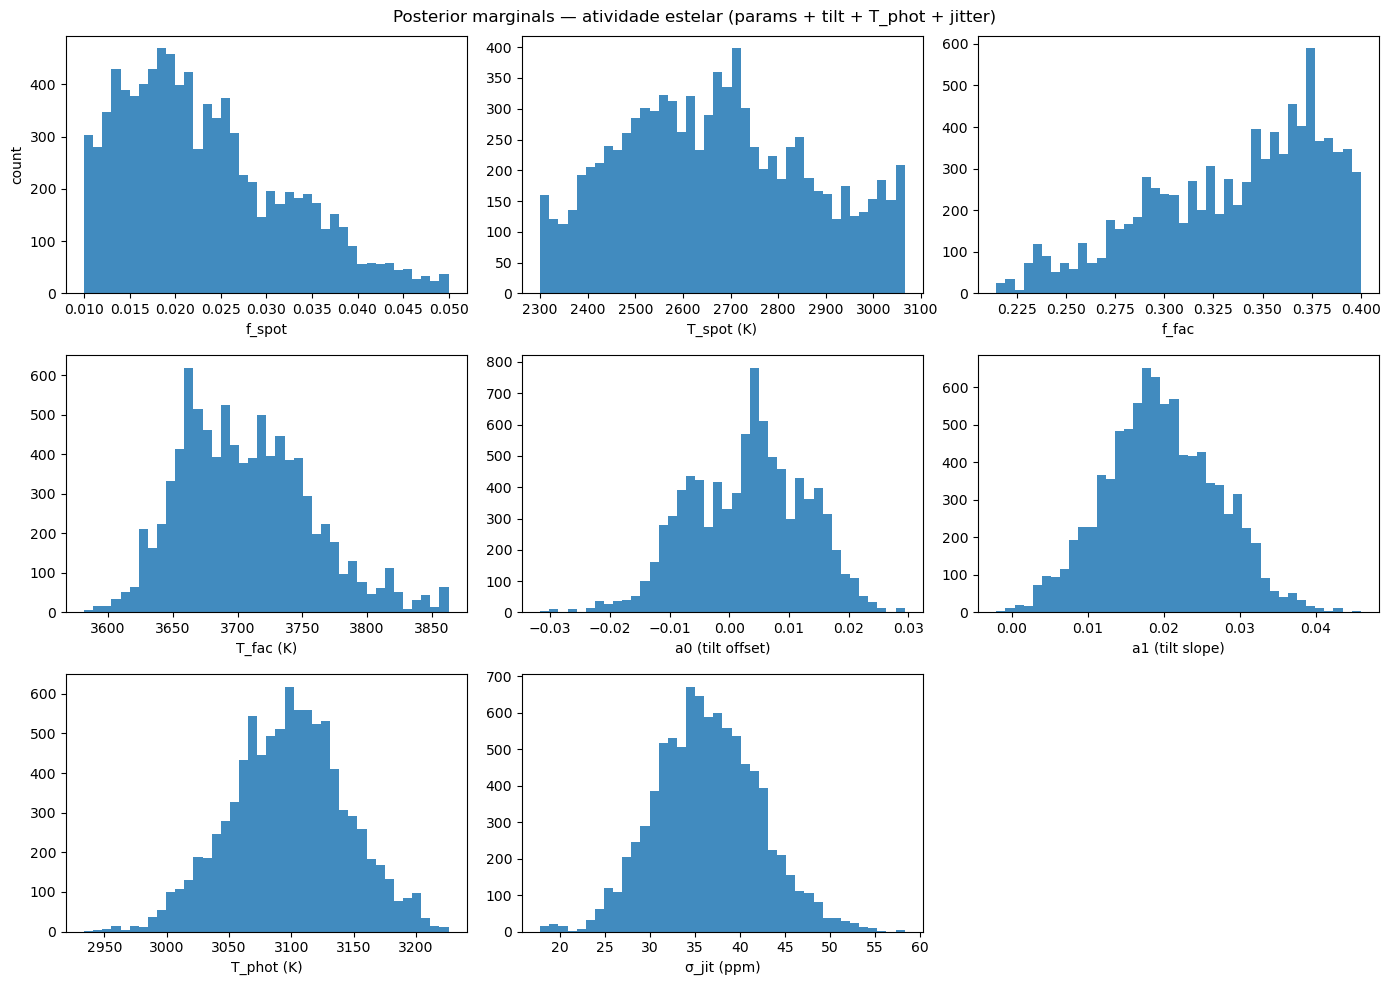

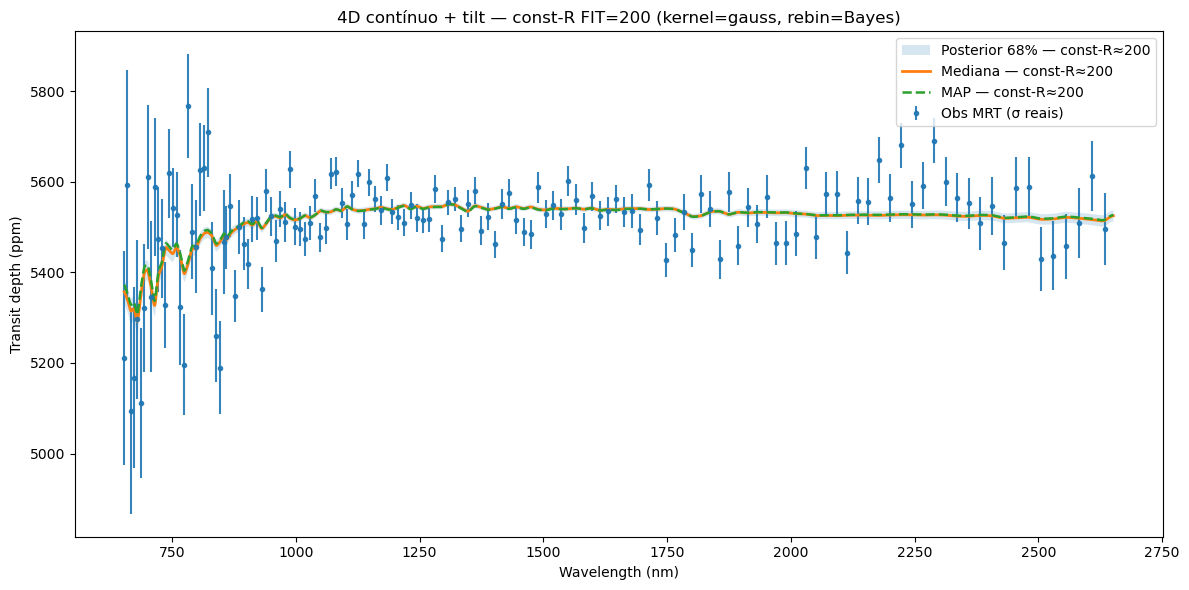

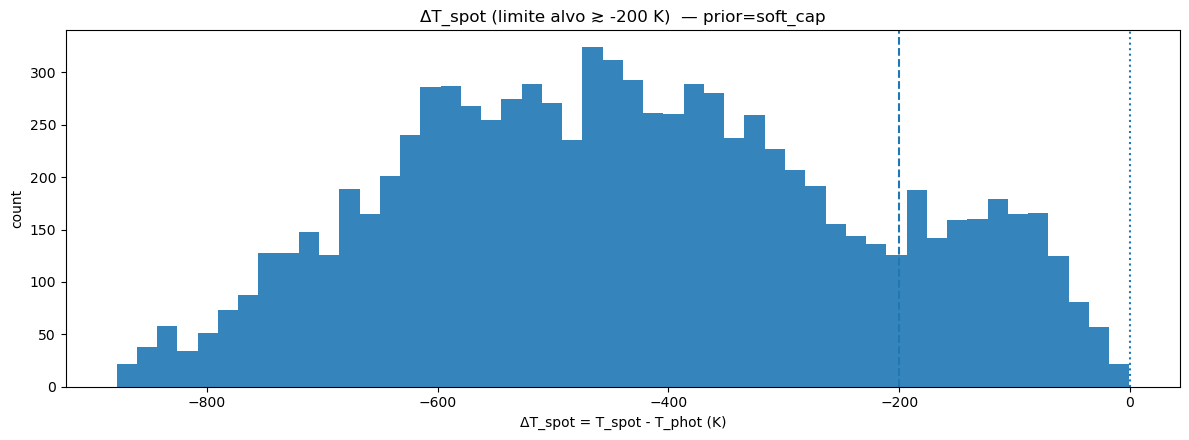

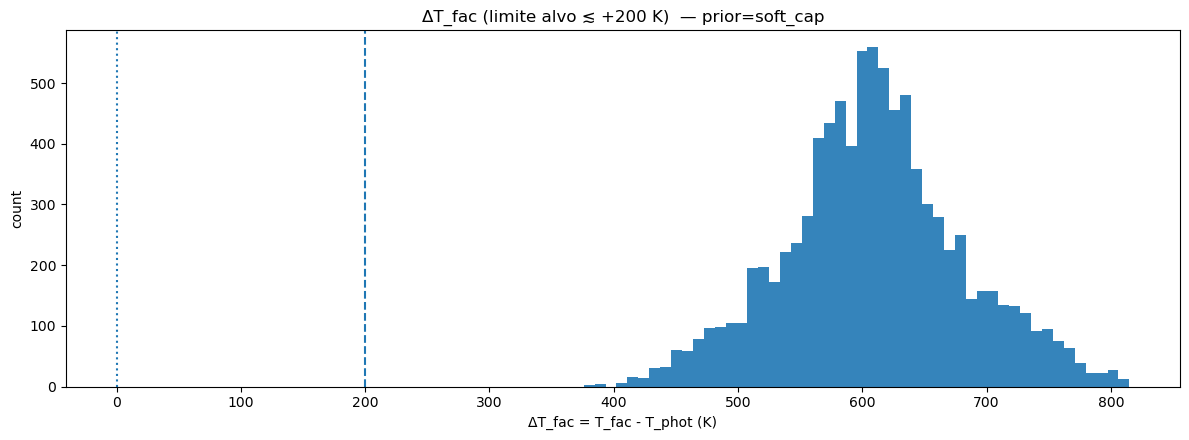

In [1]:
# -*- coding: utf-8 -*-
# Continuous MCMC (single-chain Metropolis–Hastings) + 4D interpolation (NaN-safe)
# MRT full-resolution fit (all points), heteroscedastic likelihood, optional jitter, const-R predictive band,
# nuisance tilt (tight prior).  —  Somente atividade estelar (sem linhas atmosféricas).

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, math

# ============================================================
# -------------------- GLOBAL CONFIG -------------------------
# ============================================================
GRID_KIND = "depth_ppm"  # grade já é profundidade de trânsito em ppm

# --- Scaling mode s ---
S_MODE          = "free"    # "fixed_1" | "free" | "lognormal" | "fixed_D0"
D0_FIXED_PPM    = 5500.0
D0_LOGNORM_MU   = np.log(1.0)    # média do prior (lognormal) p/ escala multiplicativa s
D0_LOGNORM_SIG  = 0.05           # ~5% de largura a priori

DATASET_LABEL = "MRT"
METHOD_LABEL  = "ECLIPSE-Xλ (cont. 4D)"
T_PHOT        = 3096.0           # valor de referência usado na geração da grade
T_PHOT_SIG    = 48.0             # prior Gaussiano
TARGET        = "LHS1140b"

grid_path = f"interpolated_results_{TARGET}_both.txt"
obs_path  = "apjlad5afat2_mrt.txt"   # tabela ASCII MRT (ordens 1 e 2)

# prediction / rebinning (apenas para a curva/banda do modelo no plot)
R_DENSE       = 100.0
R_CONST_FIT   = 200.0
CONST_R_KERNEL = "gauss"              # "gauss" | "triangular" | "box"
CONST_R_WINDOW_SIGMA = 0.8
CONST_R_WEIGHTED_MED = False

# Gentle pre-blur BEFORE rebin (se quiser matar ripple fino antes do const-R)
PRE_BLUR_R = None  # 60–100 funciona bem; None = desliga

# MCMC hyperparams (single chain MH)
RNG_SEED = 2025
N_STEPS  = 120000
BURNIN   = 30000
THIN     = 10

# Adaptação leve no burn-in
DO_ADAPT_BURNIN = True
ADAPT_EVERY     = 1000
TARGET_ACCEPT   = 0.30
ADAPT_UP        = 1.10
ADAPT_DOWN      = 0.90

# parameter bounds / priors ----------------------------------
BOUNDS_SHRINK = 0.00                  # usa todo o span da grade

# (A) Guard-rail físico
ENFORCE_PHYSICS_BOUNDS = True         # T_spot <= T_phot, T_fac >= T_phot

# (B) Priors de filling factor (moderados)
# >>> Você disse que não precisa tanto: deixei OFF por padrão. <<<
USE_BETA_PRIOR_FSPOT = False   # antes: True
USE_BETA_PRIOR_FFAC  = False   # antes: True
FSPOT_PRIOR_A, FSPOT_PRIOR_B, FSPOT_PRIOR_W = 1.0, 12.0, 0.8
FFAC_PRIOR_A,  FFAC_PRIOR_B,  FFAC_PRIOR_W  = 1.0, 12.0, 0.8
USE_HALFGAUSS_PRIOR_F = False
SIGMA_FSPOT, SIGMA_FFAC = 0.06, 0.06
W_HALFGAUSS_FSPOT = 1.0
W_HALFGAUSS_FFAC  = 1.0

# (C) Nuisance tilt (multiplicativo no contínuo)
USE_TILT = True
L0_PIVOT_NM = 1200.0
SIGMA_A0 = 0.01
SIGMA_A1 = 0.01

# (D) Jitter global na like (aditivo em quadratura)
USE_JITTER = True
JITTER_LOGNORM_MU  = np.log(80.0)   # mediana a priori ~80 ppm (ampla)
JITTER_LOGNORM_SIG = 0.8            # ~×2.2 por σ (bem amplo)

# ------------------------------------------------------------
# (NOVO) prefixo opcional para exportar uma rodada alternativa (ex.: LDCs=0)
EXPORT_PREFIX = ""  # ex.: "LDC_0_"

# predictive stack / exports
REBIN_BAYESIAN   = True
N_DRAWS_REBIN    = 2000
SAVE_COVARIANCE  = True
EXPORT_COV_NPZ   = f"{EXPORT_PREFIX}stack_covariances.npz"
EXPORT_MODELS_TXT= f"{EXPORT_PREFIX}stack_models_ECLIPSE.txt"
EXPORT_DATA_TXT  = f"{EXPORT_PREFIX}stack_data_ECLIPSE.txt"
EXPORT_PARAMS_TXT= f"{EXPORT_PREFIX}stack_params_ECLIPSE.txt"

# (NOVO) export das AMOSTRAS do posterior (para histogramas reais)
EXPORT_CHAIN_SAMPLES_TXT = f"{EXPORT_PREFIX}stack_chain_ECLIPSE.txt"

# Likelihood uncertainties — usar barras reais por padrão
EQUALIZE_ERRORS_IN_LIKE = False       # usa σ reais
EQUALIZE_KIND           = "median"    # se ligar
USE_CLIPPED_EQUALIZATION = False
MAX_WEIGHT_RATIO = 3.0

# ---- Precisão/robustez numérica -------------------------------------------
GRID_DTYPE  = np.float32
EPS_SIGMA   = 1e-6
EPS_BOUND_F = 1e-12

# ---- Amostragem para diagnósticos/validações ------------------------------
N_DIAG_DRAWS   = 2000   # draws do posterior para WAIC/DIC/PPC

# ============================================================
# [NOVO] PRIORS DE TEMPERATURA (ΔT relativos a T_phot)
# ============================================================
USE_TEMP_PRIORS   = False                 # liga/desliga bloco todo
TEMP_PRIOR_KIND   = "soft_cap"           # "soft_cap" | "hard" | "gaussian"
DTFAC_MAX_HOT     = 200.0                # K: facula "geralmente ≤ +200 K"
DTSPOT_MAX_COOL   = 200.0                # K: mancha "geralmente ≥ −200 K"
DTFAC_SOFT_SIGMA  = 40.0                 # K: 1σ da cauda quando passa do limite (facula)
DTSPOT_SOFT_SIGMA = 40.0                 # K: 1σ da cauda quando passa do limite (mancha)
DTFAC_ZERO_SIGMA  = 100.0                # K: σ p/ modo "gaussian" (opcional)
DTSPOT_ZERO_SIGMA = 100.0                # K: σ p/ modo "gaussian" (opcional)

# ------------------------------------------------------------
# limpa exports anteriores (se existirem)
for path in [EXPORT_MODELS_TXT, EXPORT_DATA_TXT, EXPORT_PARAMS_TXT, EXPORT_CHAIN_SAMPLES_TXT, EXPORT_COV_NPZ]:
    if os.path.exists(path):
        os.remove(path)
        print(f"[INFO] Previous file '{path}' removed.")

def _ensure_header(path: str, header: str):
    if (not os.path.exists(path)) or os.path.getsize(path) == 0:
        with open(path, "w", encoding="utf-8") as f:
            f.write(header + "\n")

def export_models(lam_nm, med, lo, hi, dataset: str, method: str):
    lam_um = np.asarray(lam_nm, float)/1000.0
    med = np.asarray(med, float); lo = np.asarray(lo, float); hi = np.asarray(hi, float)
    _ensure_header(EXPORT_MODELS_TXT, "dataset\tmethod\tlam_um\tmed_ppm\tlo_ppm\thi_ppm")
    with open(EXPORT_MODELS_TXT,"a", encoding="utf-8") as f:
        for x,m,l,h in zip(lam_um,med,lo,hi):
            f.write(f"{dataset}\t{method}\t{x:.9g}\t{m:.9g}\t{l:.9g}\t{h:.9g}\n")

def export_data(lam_nm, y, ylo=None, yhi=None, dataset=""):
    lam_um = np.asarray(lam_nm, float)/1000.0
    y = np.asarray(y,float)
    ylo= np.full_like(y,np.nan) if ylo is None else np.asarray(ylo,float)
    yhi= np.full_like(y,np.nan) if yhi is None else np.asarray(yhi,float)
    _ensure_header(EXPORT_DATA_TXT, "dataset\tlam_um\ty_ppm\tdy_low_ppm\tdy_high_ppm")
    with open(EXPORT_DATA_TXT,"a", encoding="utf-8") as f:
        for x,yy,lo,hi in zip(lam_um,y,ylo,yhi):
            f.write(f"{dataset}\t{x:.9g}\t{yy:.9g}\t{lo:.9g}\t{hi:.9g}\n")

def export_params(dataset, method, fsp_stats, tsp_stats, ffa_stats, tfa_stats, T_phot_for_export):
    _ensure_header(EXPORT_PARAMS_TXT,
        "dataset\tmethod\tf_spot_p16\tf_spot_p50\tf_spot_p84\t"
        "T_spot_p16\tT_spot_p50\tT_spot_p84\tf_fac_p16\tf_fac_p50\tf_fac_p84\t"
        "T_fac_p16\tT_fac_p50\tT_fac_p84\tDeltaT_spot_p50\tDeltaT_fac_p50")
    fsp16,fsp50,fsp84 = fsp_stats
    tsp16,tsp50,tsp84 = tsp_stats
    ffa16,ffa50,ffa84 = ffa_stats
    tfa16,tfa50,tfa84 = tfa_stats
    dspot = tsp50 - T_phot_for_export
    dfac  = tfa50 - T_phot_for_export
    with open(EXPORT_PARAMS_TXT,"a", encoding="utf-8") as f:
        f.write(f"{dataset}\t{method}\t{fsp16:.9g}\t{fsp50:.9g}\t{fsp84:.9g}\t"
                f"{tsp16:.9g}\t{tsp50:.9g}\t{tsp84:.9g}\t"
                f"{ffa16:.9g}\t{ffa50:.9g}\t{ffa84:.9g}\t"
                f"{tfa16:.9g}\t{tfa50:.9g}\t{tfa84:.9g}\t"
                f"{dspot:.9g}\t{dfac:.9g}\n")

# (NOVO) export das AMOSTRAS do posterior (para histogramas reais)
def export_chain_samples(samples_theta, samples_u, dataset, method, path):
    """
    Salva uma linha por amostra (já pós burn-in/thin):
    dataset, method, sample_idx, f_spot, T_spot, f_fac, T_fac, T_phot, a0, a1, sigma_jit_ppm, s, dT_spot, dT_fac
    """
    n = samples_theta.shape[0]
    if n == 0:
        print("[WARN] chain vazio — nada exportado.")
        return
    # escala s por amostra
    if S_MODE in ("free","lognormal"):
        s_vec = np.exp(samples_u)
    elif S_MODE == "fixed_1":
        s_vec = np.ones(n, float)
    elif S_MODE == "fixed_D0":
        s_vec = np.full(n, float(D0_FIXED_PPM))
    else:
        s_vec = np.ones(n, float)

    # jitter por amostra
    if USE_JITTER:
        sigjit_ppm = np.exp(samples_theta[:,7])  # IDX_LNJ = 7
    else:
        sigjit_ppm = np.zeros(n, float)

    # deltas de temperatura
    dT_spot = samples_theta[:,1] - samples_theta[:,6]  # T_spot - T_phot
    dT_fac  = samples_theta[:,3] - samples_theta[:,6]  # T_fac  - T_phot

    _ensure_header(path,
        "dataset\tmethod\tsample_idx\tf_spot\tT_spot\tf_fac\tT_fac\tT_phot\t"
        "a0\ta1\tsigma_jit_ppm\ts\tdT_spot\tdT_fac"
    )
    with open(path, "a", encoding="utf-8") as f:
        for i in range(n):
            th = samples_theta[i]
            f.write(
                f"{dataset}\t{method}\t{i}\t"
                f"{th[0]:.9g}\t{th[1]:.9g}\t{th[2]:.9g}\t{th[3]:.9g}\t{th[6]:.9g}\t"
                f"{th[4]:.9g}\t{th[5]:.9g}\t{sigjit_ppm[i]:.9g}\t{s_vec[i]:.9g}\t"
                f"{dT_spot[i]:.9g}\t{dT_fac[i]:.9g}\n"
            )
    print(f"[OK] posterior chain exportado: {path}  ({n} amostras)")

def percentis(a): return tuple(np.percentile(np.asarray(a,float),[16,50,84]))

# ============================================================
# -------------------- LOAD GRID & OBS -----------------------
# ============================================================
if not os.path.exists(grid_path):
    raise FileNotFoundError(grid_path)

df_all = pd.read_csv(grid_path)

# aliases robustos
aliases = {
    "T_spot":   "tempSpot"   if "tempSpot"   in df_all.columns else "T_spot",
    "T_facula": "tempFacula" if "tempFacula" in df_all.columns else "T_facula",
}
col_Ts = aliases["T_spot"]; col_Tf = aliases["T_facula"]

req = {"f_spot", col_Ts, "f_facula", col_Tf, "wavelength", "D_lambda"}
missing = req - set(df_all.columns)
if missing:
    raise RuntimeError(f"Grid missing columns: {sorted(missing)}")

# somente linhas 'both'
df = df_all.loc[df_all['f_spot'].notna() & df_all['f_facula'].notna()].copy()
if df.empty:
    raise RuntimeError("No 'both' rows in the grid. Re-run the simulator with DO_BOTH=True.")

# Valores únicos ordenados
f_spot_vals = np.sort(df['f_spot'].unique())
T_spot_vals = np.sort(df[col_Ts].unique())
f_fac_vals  = np.sort(df['f_facula'].unique())
T_fac_vals  = np.sort(df[col_Tf].unique())
lam_grid_nm = np.sort(df['wavelength'].unique())

# --- Preenche o tensor 5D (vetorizado)
M_full = np.full(
    (len(f_spot_vals),len(T_spot_vals),len(f_fac_vals),len(T_fac_vals),len(lam_grid_nm)),
    np.nan, dtype=GRID_DTYPE
)
I = np.searchsorted(f_spot_vals, df['f_spot'].to_numpy())
J = np.searchsorted(T_spot_vals, df[col_Ts].to_numpy())
K = np.searchsorted(f_fac_vals,  df['f_facula'].to_numpy())
L = np.searchsorted(T_fac_vals,  df[col_Tf].to_numpy())
P = np.searchsorted(lam_grid_nm, df['wavelength'].to_numpy())
vals = df['D_lambda'].to_numpy().astype(GRID_DTYPE)
M_full[I, J, K, L, P] = vals

# ---- OBS (MRT ASCII) ----
def load_mrt_lhs1140b(path: str):
    """Lê CWave, Width, Depth-b, e_Depth-b (ordens 1 e 2)."""
    lam_um, depth_b, edepth_b = [], [], []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if (not s) or s.startswith(("#",";")):
                continue
            toks = s.replace(",", " ").split()
            if len(toks) < 7:
                continue
            try:
                cw, db, edb = float(toks[0]), float(toks[2]), float(toks[3])
            except Exception:
                continue
            lam_um.append(cw); depth_b.append(db); edepth_b.append(edb)
    if not lam_um:
        raise RuntimeError(f"Could not parse '{path}'.")
    lam_um = np.asarray(lam_um, float)
    depth_b = np.asarray(depth_b, float)
    edepth_b = np.asarray(edepth_b, float)
    order = np.argsort(lam_um)
    lam_um, depth_b, edepth_b = lam_um[order], depth_b[order], edepth_b[order]
    lam_nm = lam_um * 1000.0
    return lam_nm, depth_b, edepth_b, edepth_b  # erros simétricos -> split-normal usa isto

lam_obs_nm, y_obs, dy_low, dy_high = load_mrt_lhs1140b(obs_path)

# faixa comum com a grade
m_in = (lam_obs_nm>=lam_grid_nm.min()) & (lam_obs_nm<=lam_grid_nm.max())
lam_obs_in, y_in = lam_obs_nm[m_in], y_obs[m_in]
dy_low_in, dy_high_in = dy_low[m_in], dy_high[m_in]
order = np.argsort(lam_obs_in)
lam_obs_in, y_in = lam_obs_in[order], y_in[order]
dy_low_in, dy_high_in = dy_low_in[order], dy_high_in[order]
print(f"[DATA] MRT total={len(lam_obs_nm)} | used (within grid)={len(lam_obs_in)}")

# --- barras REAIS no PLOT ---
dy_low_plot  = dy_low_in.copy()
dy_high_plot = dy_high_in.copy()

# --- barras para a LIKE ---
if EQUALIZE_ERRORS_IN_LIKE:
    sigma_vec = 0.5*(dy_low_in.astype(float) + dy_high_in.astype(float))
    sigma_vec = np.maximum(sigma_vec, EPS_SIGMA)
    if USE_CLIPPED_EQUALIZATION:
        sigma_med = float(np.nanmedian(sigma_vec))
        lo_cap, hi_cap = sigma_med/np.sqrt(MAX_WEIGHT_RATIO), sigma_med*np.sqrt(MAX_WEIGHT_RATIO)
        sigma_clip = np.clip(sigma_vec, lo_cap, hi_cap)
        dy_low_fit  = sigma_clip.copy()
        dy_high_fit = sigma_clip.copy()
        print(f"[DATA] likelihood uses CLIPPED σ (ratio ≤ {MAX_WEIGHT_RATIO}×); plots use REAL bars.")
    else:
        if   EQUALIZE_KIND.lower()=="mean": sigma_star=float(np.nanmean(sigma_vec))
        elif EQUALIZE_KIND.lower()=="rms":  sigma_star=float(np.sqrt(np.nanmean(sigma_vec**2)))
        else:                               sigma_star=float(np.nanmedian(sigma_vec))
        sigma_star = max(sigma_star, EPS_SIGMA)
        dy_low_fit  = np.full_like(dy_low_in,  sigma_star, dtype=float)
        dy_high_fit = np.full_like(dy_high_in, sigma_star, dtype=float)
        print(f"[DATA] likelihood uses equalized σ = {sigma_star:.3f} ppm; plots use REAL bars.")
else:
    dy_low_fit  = np.maximum(dy_low_in.copy(),  EPS_SIGMA)
    dy_high_fit = np.maximum(dy_high_in.copy(), EPS_SIGMA)
    print("[DATA] likelihood uses REAL per-point uncertainties (no equalization).")

# ============================================================
# ---------------- Throughput helpers (optional) -------------
# ============================================================
def _gauss_blur_nm(x_nm, y, R_eff):
    """Gaussian blur with constant resolving power R over wavelength grid in nm."""
    import numpy as _np
    x = _np.asarray(x_nm, float)
    y = _np.asarray(y, float)
    if R_eff is None:
        return y.copy()
    try:
        R_eff = float(R_eff)
    except Exception:
        return y.copy()
    if R_eff <= 0 or x.size != y.size or not _np.any(_np.isfinite(y)):
        return y.copy()
    idx = _np.argsort(x); x_sorted = x[idx]; y_sorted = y[idx]
    inv_idx = _np.empty_like(idx); inv_idx[idx] = _np.arange(idx.size)
    n = x_sorted.size; out_sorted = _np.full(n, _np.nan, dtype=float)
    INV_2SQRT2LN2 = 1.0 / 2.354820045
    N_SIGMA = 5.0
    for i in range(n):
        L = x_sorted[i]; fwhm = L / R_eff; sigma = fwhm * INV_2SQRT2LN2
        if not _np.isfinite(sigma) or sigma <= 0.0:
            out_sorted[i] = y_sorted[i] if _np.isfinite(y_sorted[i]) else _np.nan; continue
        left = L - N_SIGMA * sigma; right = L + N_SIGMA * sigma
        j0 = _np.searchsorted(x_sorted, left, side='left')
        j1 = _np.searchsorted(x_sorted, right, side='right')
        xs = x_sorted[j0:j1]; ys = y_sorted[j0:j1]; fin = _np.isfinite(ys)
        if not _np.any(fin): out_sorted[i] = _np.nan; continue
        dx = (xs - L) / sigma; w = _np.exp(-0.5 * dx * dx); w = w[fin]; ys = ys[fin]
        sw = _np.nansum(w); out_sorted[i] = _np.nansum(w * ys) / sw if sw>0 else _np.nan
    out = _np.empty_like(out_sorted); out[inv_idx] = out_sorted; return out

# ============================================================
# ---- λ interpolation & 4D interp (NaN-safe) ----------------
# ============================================================
def _interp_model_lambda(lam_grid: np.ndarray, y_on_grid: np.ndarray, lam_target: np.ndarray) -> np.ndarray:
    lam_grid   = np.asarray(lam_grid,   float)
    y_on_grid  = np.asarray(y_on_grid,  float)
    lam_target = np.asarray(lam_target, float)
    # preenche buracos pequenos na grade
    if np.isnan(y_on_grid).any():
        m = np.isfinite(y_on_grid)
        if m.sum() >= 2:
            y_on_grid = np.interp(lam_grid, lam_grid[m], y_on_grid[m])
        else:
            return np.full_like(lam_target, np.nan, float)
    order = np.argsort(lam_grid)
    lx  = np.log(lam_grid[order])
    ly  = y_on_grid[order]
    lxt = np.log(lam_target)
    out = np.interp(lxt, lx, ly)
    out[(lam_target < lam_grid.min()) | (lam_target > lam_grid.max())] = np.nan
    return out

def _interp4_params_nan_safe(
    f_spot_vals, T_spot_vals, f_fac_vals, T_fac_vals, M_full,
    f_spot, T_spot, f_fac, T_fac
) -> np.ndarray:
    """4D lerp com manejo de NaN nos vértices."""
    def _br(g, x):
        g = np.asarray(g, float)
        if x <= g[0]:  return 0, 0, 0.0
        if x >= g[-1]: return len(g)-1, len(g)-1, 0.0
        i1 = int(np.searchsorted(g, x)); i0 = i1 - 1
        x0, x1 = g[i0], g[i1]
        t = 0.0 if x1 == x0 else (x - x0)/(x1 - x0)
        return i0, i1, float(t)

    i0,i1,tf = _br(f_spot_vals, f_spot)
    j0,j1,tt = _br(T_spot_vals, T_spot)
    k0,k1,tg = _br(f_fac_vals,  f_fac)
    l0,l1,th = _br(T_fac_vals,  T_fac)

    w = np.array([
        (1-tf)*(1-tt)*(1-tg)*(1-th),
         tf   *(1-tt)*(1-tg)*(1-th),
        (1-tf)* tt   *(1-tg)*(1-th),
         tf   * tt   *(1-tg)*(1-th),
        (1-tf)*(1-tt)* tg   *(1-th),
         tf   *(1-tt)* tg   *(1-th),
        (1-tf)* tt   * tg   * (1-th),
         tf   * tt   * tg   * (1-th),
        (1-tf)*(1-tt)*(1-tg)* th,
         tf   *(1-tt)*(1-tg)* th,
        (1-tf)* tt   *(1-tg)* th,
         tf   * tt   *(1-tg)* th,
        (1-tf)*(1-tt)* tg   * th,
         tf   *(1-tt)* tg   * th,
        (1-tf)* tt   * tg   * th,
         tf   * tt   * tg   * th
    ], dtype=float)

    cubes = [
        M_full[i0,j0,k0,l0,:], M_full[i1,j0,k0,l0,:],
        M_full[i0,j1,k0,l0,:], M_full[i1,j1,k0,l0,:],
        M_full[i0,j0,k1,l0,:], M_full[i1,j0,k1,l0,:],
        M_full[i0,j1,k1,l0,:], M_full[i1,j1,k1,l0,:],
        M_full[i0,j0,k0,l1,:], M_full[i1,j0,k0,l1,:],
        M_full[i0,j1,k0,l1,:], M_full[i1,j1,k0,l1,:],
        M_full[i0,j0,k1,l1,:], M_full[i1,j0,k1,l1,:],
        M_full[i0,j1,k1,l1,:], M_full[i1,j1,k1,l1,:],
    ]
    C = np.vstack(cubes)              # (16, nλ)
    finite = np.isfinite(C)           # (16, nλ)
    W = w[:, None] * finite           # zera pesos onde NaN
    Wsum = W.sum(axis=0)              # (nλ,)
    out = np.full(C.shape[1], np.nan)
    ok = Wsum > 0
    if np.any(ok):
        out[ok] = (W[:, ok] * C[:, ok]).sum(axis=0) / Wsum[ok]
    return out

# ============================================================
# ---------------- Likelihood & Priors -----------------------
# ============================================================
def loglike_split_normal(y, dy_low, dy_high, m_q):
    """Split-normal (assimétrica) na profundidade real (ppm)."""
    if np.isnan(m_q).any(): return -np.inf
    dy_low  = np.maximum(dy_low,  EPS_SIGMA)
    dy_high = np.maximum(dy_high, EPS_SIGMA)
    r = y - m_q
    logC  = 0.5*np.log(2.0/np.pi) - np.log(dy_low + dy_high)
    sigma = np.where(r>=0.0, dy_high, dy_low)
    sigma = np.maximum(sigma, EPS_SIGMA)
    quad  = -0.5*(r**2)/(sigma**2)
    return float(np.sum(logC + quad))

def loglike_split_normal_pointwise(y, dy_low, dy_high, m_q):
    dy_low  = np.maximum(dy_low,  EPS_SIGMA)
    dy_high = np.maximum(dy_high, EPS_SIGMA)
    r = y - m_q
    logC  = 0.5*np.log(2.0/np.pi) - np.log(dy_low + dy_high)
    sigma = np.where(r>=0.0, dy_high, dy_low)
    sigma = np.maximum(sigma, EPS_SIGMA)
    quad  = -0.5*(r**2)/(sigma**2)
    return logC + quad  # shape (N,)

def _logbeta(a,b): return math.lgamma(a) + math.lgamma(b) - math.lgamma(a+b)

def _logpdf_beta_on_interval(x, lo, hi, a, b):
    # intervalo aberto (lo, hi) — compatível com reflexão aberta
    if not (lo < x < hi): return -np.inf
    z = (x - lo) / (hi - lo)
    if z<=0.0 or z>=1.0: return -np.inf
    return (a-1)*math.log(z) + (b-1)*math.log(1-z) - _logbeta(a,b) - math.log(hi-lo)

def _half_gauss_penalty(x, sigma):
    if not np.isfinite(x) or sigma<=0: return 0.0
    return -0.5 * (x/sigma)**2

def _shrink(lo, hi, frac):
    if not np.isfinite(lo) or not np.isfinite(hi) or hi<=lo: return lo, hi
    span = hi - lo
    return lo + frac*span, hi - frac*span

# [NOVO] Prior de temperatura
def _logprior_temp(T_spot, T_fac, Tphot):
    if not USE_TEMP_PRIORS:
        return 0.0
    dT_spot = T_spot - Tphot    # tipicamente ≤ 0
    dT_fac  = T_fac  - Tphot    # tipicamente ≥ 0
    lp = 0.0
    if TEMP_PRIOR_KIND == "hard":
        # top-hat duro: rejeita extrapolações
        if dT_spot < -DTSPOT_MAX_COOL or dT_fac > DTFAC_MAX_HOT:
            return -np.inf
        return 0.0
    elif TEMP_PRIOR_KIND == "soft_cap":
        # sem penalização dentro do intervalo; cauda Gaussiana fora
        excess_cool = max(0.0, (-dT_spot) - DTSPOT_MAX_COOL)  # quanto passou de -200 K
        excess_hot  = max(0.0, dT_fac - DTFAC_MAX_HOT)        # quanto passou de +200 K
        if excess_cool > 0.0:
            lp += -0.5*(excess_cool/DTSPOT_SOFT_SIGMA)**2
        if excess_hot  > 0.0:
            lp += -0.5*(excess_hot /DTFAC_SOFT_SIGMA )**2
        return lp
    elif TEMP_PRIOR_KIND == "gaussian":
        # prefere |ΔT| pequeno (simétrico ao redor de 0)
        lp += -0.5*(dT_spot/DTSPOT_ZERO_SIGMA)**2 - np.log(DTSPOT_ZERO_SIGMA*np.sqrt(2*np.pi))
        lp += -0.5*(dT_fac /DTFAC_ZERO_SIGMA )**2 - np.log(DTFAC_ZERO_SIGMA*np.sqrt(2*np.pi))
        return lp
    else:
        return 0.0

# bounds reduzidos (se desejado)
fspot_lo_raw, fspot_hi_raw = float(f_spot_vals.min()), float(f_spot_vals.max())
Tspot_lo_raw, Tspot_hi_raw = float(T_spot_vals.min()), float(T_spot_vals.max())
ffac_lo_raw,  ffac_hi_raw  = float(f_fac_vals.min()),  float(f_fac_vals.max())
Tfac_lo_raw,  Tfac_hi_raw  = float(T_fac_vals.min()),  float(T_fac_vals.max())

fspot_lo, fspot_hi = _shrink(fspot_lo_raw, fspot_hi_raw, BOUNDS_SHRINK)
Tspot_lo, Tspot_hi = _shrink(Tspot_lo_raw, Tspot_hi_raw, BOUNDS_SHRINK)
ffac_lo,  ffac_hi  = _shrink(ffac_lo_raw,  ffac_hi_raw,  BOUNDS_SHRINK)
Tfac_lo,  Tfac_hi  = _shrink(Tfac_lo_raw,  Tfac_hi_raw,  BOUNDS_SHRINK)

# Índices de parâmetros (8D): [f_spot, T_spot, f_fac, T_fac, a0, a1, Tphot, ln_sigma_jit]
IDX_FSP, IDX_TSP, IDX_FFA, IDX_TFA, IDX_A0, IDX_A1, IDX_TPH, IDX_LNJ = range(8)

rng = np.random.default_rng(RNG_SEED)
theta_cur = np.array([
    0.5*(fspot_lo+fspot_hi),   # f_spot
    0.5*(Tspot_lo+Tspot_hi),   # T_spot
    0.5*(ffac_lo +ffac_hi ),   # f_fac
    0.5*(Tfac_lo +Tfac_hi ),   # T_fac
    0.0,                       # a0 (tilt offset)
    0.0,                       # a1 (tilt slope)
    T_PHOT,                    # T_phot (livre com prior Gauss)
    np.log(60.0)               # ln σ_jit (ppm) — inicial
], dtype=float)
u_cur = 0.0  # ln(s)

def _logprior_params(theta):
    f_spot, T_spot, f_fac, T_fac, a0, a1, Tphot, ln_sigjit = theta
    # hard bounds (abertos)
    if not (fspot_lo < f_spot < fspot_hi and
            Tspot_lo < T_spot < Tspot_hi and
            ffac_lo  < f_fac  < ffac_hi  and
            Tfac_lo  < T_fac  < Tfac_hi):
        return -np.inf
    # física (usa Tphot LIVRE)
    if ENFORCE_PHYSICS_BOUNDS:
        if (T_spot > Tphot) or (T_fac < Tphot):
            return -np.inf
    lp = 0.0
    # Priors Beta (opcionais)
    if USE_BETA_PRIOR_FFAC and FFAC_PRIOR_W>0:
        lp += FFAC_PRIOR_W * _logpdf_beta_on_interval(f_fac, ffac_lo, ffac_hi, FFAC_PRIOR_A, FFAC_PRIOR_B)
    if USE_BETA_PRIOR_FSPOT and FSPOT_PRIOR_W>0:
        lp += FSPOT_PRIOR_W * _logpdf_beta_on_interval(f_spot, fspot_lo, fspot_hi, FSPOT_PRIOR_A, FSPOT_PRIOR_B)
    # Half-Gauss (opcional) em f's
    if USE_HALFGAUSS_PRIOR_F and SIGMA_FSPOT>0:
        lp += W_HALFGAUSS_FSPOT * _half_gauss_penalty(max(f_spot, 0.0), SIGMA_FSPOT)
    if USE_HALFGAUSS_PRIOR_F and SIGMA_FFAC>0:
        lp += W_HALFGAUSS_FFAC  * _half_gauss_penalty(max(f_fac,  0.0), SIGMA_FFAC)

    # [NOVO] prior de temperatura relativo a Tphot
    lp += _logprior_temp(T_spot, T_fac, Tphot)
    return lp

def _logprior_tilt(a0, a1):
    if not USE_TILT:
        return 0.0
    lp0 = -0.5*(a0/SIGMA_A0)**2 - np.log(SIGMA_A0*np.sqrt(2*np.pi))
    lp1 = -0.5*(a1/SIGMA_A1)**2 - np.log(SIGMA_A1*np.sqrt(2*np.pi))
    return lp0 + lp1

def _logprior_Tphot(Tphot):
    # Gaussiano centrado em T_PHOT ± T_PHOT_SIG
    sig = float(T_PHOT_SIG)
    return -0.5*((Tphot - T_PHOT)/sig)**2 - np.log(sig*np.sqrt(2*np.pi))

def _logprior_jitter(ln_sigjit):
    if not USE_JITTER:
        return 0.0
    mu, sg = JITTER_LOGNORM_MU, JITTER_LOGNORM_SIG
    # prior normal em ln σ_jit (i.e., σ_jit ~ LogNormal)
    return -0.5*((ln_sigjit - mu)/sg)**2 - np.log(sg*np.sqrt(2*np.pi))

def logpost_cont(theta8, u):
    # unpack
    f_spot, T_spot, f_fac, T_fac, a0, a1, Tphot, ln_sigjit = theta8
    # priors
    lp_params = _logprior_params(theta8)
    if not np.isfinite(lp_params): return -np.inf
    lp_tilt   = _logprior_tilt(a0, a1)
    lp_Tphot  = _logprior_Tphot(Tphot)
    lp_jit    = _logprior_jitter(ln_sigjit)

    # escala s
    if S_MODE=="fixed_1" and GRID_KIND=="depth_ppm":
        s=1.0; lp_s=0.0
    elif S_MODE=="fixed_D0" and GRID_KIND=="epsilon":
        if not (np.isfinite(D0_FIXED_PPM) and D0_FIXED_PPM>0): return -np.inf
        s=float(D0_FIXED_PPM); lp_s=0.0
    elif S_MODE=="lognormal":
        s=np.exp(u)
        lp_s = -0.5*((u-D0_LOGNORM_MU)**2)/(D0_LOGNORM_SIG**2) - np.log(D0_LOGNORM_SIG) - 0.5*np.log(2*np.pi)
        if not np.isfinite(s) or s<=0: return -np.inf
    elif S_MODE=="free":
        s=np.exp(u); lp_s=0.0
        if not np.isfinite(s) or s<=0: return -np.inf
    else:
        return -np.inf

    # espectro na grade e nos λ observados
    spec_grid = _interp4_params_nan_safe(
        f_spot_vals, T_spot_vals, f_fac_vals, T_fac_vals, M_full,
        f_spot, T_spot, f_fac, T_fac
    )
    if not np.any(np.isfinite(spec_grid)):
        return -np.inf

    m_q = _interp_model_lambda(lam_grid_nm, spec_grid, lam_obs_in)
    if USE_TILT:
        tilt_obs = np.exp(a0 + a1*np.log(lam_obs_in / L0_PIVOT_NM))
        m_q = s * m_q * tilt_obs
    else:
        m_q = s * m_q

    # σ efetivo da like (com jitter em quadratura)
    if USE_JITTER:
        sig_jit = np.exp(ln_sigjit)
        dy_low_eff  = np.sqrt(dy_low_fit**2  + sig_jit**2)
        dy_high_eff = np.sqrt(dy_high_fit**2 + sig_jit**2)
    else:
        dy_low_eff, dy_high_eff = dy_low_fit, dy_high_fit

    ll = loglike_split_normal(y_in, dy_low_eff, dy_high_eff, m_q)
    return ll + lp_params + lp_tilt + lp_Tphot + lp_jit + lp_s

# proposals (std)
sig_f   = 0.10*(fspot_hi - fspot_lo) if fspot_hi>fspot_lo else 1e-3
sig_Ts  = 0.10*(Tspot_hi - Tspot_lo) if Tspot_hi>Tspot_lo else 1.0
sig_ff  = 0.10*(ffac_hi  - ffac_lo ) if ffac_hi >ffac_lo  else 1e-3
sig_Tf  = 0.10*(Tfac_hi  - Tfac_lo ) if Tfac_hi >Tfac_lo  else 1.0
sig_a0  = SIGMA_A0
sig_a1  = SIGMA_A1
sig_Tph = 40.0
sig_lnj = 0.20
sig_u   = 0.08

def _reflect_open(x, lo, hi):
    """Reflexão em (lo, hi)."""
    if not (np.isfinite(lo) and np.isfinite(hi)) or hi <= lo:
        return x
    span = hi - lo
    eps = EPS_BOUND_F * span
    y = (x - lo) % (2.0 * span)
    z = (lo + y) if y <= span else (hi - (y - span))
    if z <= lo: z = lo + eps
    if z >= hi: z = hi - eps
    return z

def propose_theta(theta8):
    # 70% atualiza 1 param; 30% bloco completo
    if rng.random() < 0.7:
        which = rng.integers(0,8)
        step = np.zeros(8)
        if   which==IDX_FSP: step[IDX_FSP] = rng.normal(0.0, sig_f)
        elif which==IDX_TSP: step[IDX_TSP] = rng.normal(0.0, sig_Ts)
        elif which==IDX_FFA: step[IDX_FFA] = rng.normal(0.0, sig_ff)
        elif which==IDX_TFA: step[IDX_TFA] = rng.normal(0.0, sig_Tf)
        elif which==IDX_A0:  step[IDX_A0]  = rng.normal(0.0, sig_a0)
        elif which==IDX_A1:  step[IDX_A1]  = rng.normal(0.0, sig_a1)
        elif which==IDX_TPH: step[IDX_TPH] = rng.normal(0.0, sig_Tph)
        else:                 step[IDX_LNJ] = rng.normal(0.0, sig_lnj)
    else:
        step = np.array([rng.normal(0.0, sig_f),
                         rng.normal(0.0, sig_Ts),
                         rng.normal(0.0, sig_ff),
                         rng.normal(0.0, sig_Tf),
                         rng.normal(0.0, sig_a0),
                         rng.normal(0.0, sig_a1),
                         rng.normal(0.0, sig_Tph),
                         rng.normal(0.0, sig_lnj)])
    new = np.array(theta8, float)
    new[IDX_FSP] = _reflect_open(new[IDX_FSP] + step[IDX_FSP], fspot_lo, fspot_hi)
    new[IDX_TSP] = _reflect_open(new[IDX_TSP] + step[IDX_TSP], Tspot_lo, Tspot_hi)
    new[IDX_FFA] = _reflect_open(new[IDX_FFA] + step[IDX_FFA], ffac_lo,  ffac_hi)
    new[IDX_TFA] = _reflect_open(new[IDX_TFA] + step[IDX_TFA], Tfac_lo,  Tfac_hi)
    new[IDX_A0] += step[IDX_A0]
    new[IDX_A1] += step[IDX_A1]
    new[IDX_TPH] += step[IDX_TPH]            # sem reflexão; prior Gauss “segura”
    new[IDX_LNJ] += step[IDX_LNJ]            # ln σ_jit é R-linear
    return new

def propose_u(u): return u + rng.normal(0.0, sig_u)

# -------- coarse grid seed ----------
seed_logp = -np.inf
seed = None
for f_sp in np.linspace(fspot_lo, fspot_hi, 6):
  for Ts in np.linspace(Tspot_lo, Tspot_hi, 6):
    for f_fa in np.linspace(ffac_lo, ffac_hi, 6):
      for Tf in np.linspace(Tfac_lo, Tfac_hi, 6):
        trial = np.array([f_sp, Ts, f_fa, Tf, 0.0, 0.0, T_PHOT, np.log(60.0)])
        lp = logpost_cont(trial, 0.0)
        if np.isfinite(lp) and lp > seed_logp:
            seed_logp, seed = lp, trial
if seed is not None:
    theta_cur[:] = seed
    u_cur = 0.0
    logp_cur = seed_logp
    best = {'theta': np.array(seed,float), 'u': u_cur, 'logp': seed_logp}
    print(f"[seed] coarse init -> {seed}  logp={seed_logp:.2f}")
else:
    logp_cur = logpost_cont(theta_cur, u_cur)
    best={'theta':theta_cur.copy(),'u':u_cur,'logp':logp_cur}

# ---------------------- run MH MCMC -------------------------
samples_theta=[]; samples_u=[]
accepts = 0
accepts_window = 0

for t in range(N_STEPS):
    if rng.random()<0.6:
        cand_theta, cand_u = propose_theta(theta_cur), u_cur
    else:
        cand_theta, cand_u = theta_cur, propose_u(u_cur)

    logp_cand = logpost_cont(cand_theta, cand_u)
    if np.isfinite(logp_cand) and (logp_cand - logp_cur) >= np.log(rng.random()):
        theta_cur, u_cur, logp_cur = cand_theta, cand_u, logp_cand
        accepts += 1
        accepts_window += 1
        if logp_cur > best['logp']:
            best={'theta':theta_cur.copy(),'u':u_cur,'logp':logp_cur}

    # adaptação leve no burn-in
    if DO_ADAPT_BURNIN and (t+1)<=BURNIN and (t+1)%ADAPT_EVERY==0:
        acc_rate_win = accepts_window / float(ADAPT_EVERY)
        scale = ADAPT_UP if acc_rate_win > TARGET_ACCEPT else ADAPT_DOWN
        sig_f  *= scale; sig_Ts *= scale; sig_ff *= scale; sig_Tf *= scale
        sig_a0 *= scale; sig_a1 *= scale; sig_Tph *= scale; sig_lnj *= scale; sig_u *= scale
        print(f"[adapt] t={t+1} acc_win={acc_rate_win:.3f} -> scale {scale:.2f}")
        accepts_window = 0

    if t>=BURNIN and (t-BURNIN)%THIN==0:
        samples_theta.append(theta_cur.copy()); samples_u.append(u_cur)

acc_rate = accepts / float(N_STEPS)
print(f"[diag] acceptance ~ {acc_rate:.3f}")

samples_theta = np.array(samples_theta); samples_u = np.array(samples_u)
if samples_theta.size==0:
    raise RuntimeError("Empty chain after burn-in/thin.")

# unpack MAP
f_best,Ts_best,ff_best,Tf_best,a0_best,a1_best,Tphot_best,lnjit_best = best['theta']
s_best = 1.0 if S_MODE=="fixed_1" else (float(D0_FIXED_PPM) if S_MODE=="fixed_D0" else float(np.exp(best['u'])))
sigjit_best = float(np.exp(lnjit_best))
print(f"[MAP] f_spot={f_best:.6f}  T_spot={Ts_best:.1f}  f_fac={ff_best:.6f}  T_fac={Tf_best:.1f}  "
      f"a0={a0_best:+.4f}  a1={a1_best:+.4f}  T_phot={Tphot_best:.1f}  σ_jit≈{sigjit_best:.1f} ppm  s={s_best:.5f}")

# sanity: espectro do MAP na grade
spec_try = _interp4_params_nan_safe(f_spot_vals, T_spot_vals, f_fac_vals, T_fac_vals, M_full,
                                    f_best, Ts_best, ff_best, Tf_best)
print(f"[diag] MAP spectrum NaNs on grid: {int(np.isnan(spec_try).sum())}")

# ============================================================
# --------- Predictive bands + constant-R rebin --------------
# ============================================================
def predictive_band_from_chain_cont(samples_theta8, samples_u, lam_target_nm, seed=7, n_draws=2000):
    rng_local = np.random.default_rng(seed)
    take = rng_local.choice(len(samples_theta8), size=min(n_draws, len(samples_theta8)), replace=False)
    stack = []
    for h in take:
        f_sp, Ts, ff, Tf, a0, a1, Tph, lnj = samples_theta8[h]
        s_here = 1.0 if S_MODE=="fixed_1" else (np.exp(samples_u[h]) if samples_u.size else 1.0)
        spec_grid = _interp4_params_nan_safe(
            f_spot_vals, T_spot_vals, f_fac_vals, T_fac_vals, M_full, f_sp, Ts, ff, Tf
        )
        m_q = _interp_model_lambda(lam_grid_nm, spec_grid, lam_target_nm) * s_here
        if USE_TILT:
            tilt = np.exp(a0 + a1*np.log(lam_target_nm / L0_PIVOT_NM))
            m_q = m_q * tilt
        stack.append(m_q)
    S = np.asarray(stack, float)
    # estatísticas robustas colunares
    med = np.full(S.shape[1], np.nan)
    lo  = np.full(S.shape[1], np.nan)
    hi  = np.full(S.shape[1], np.nan)
    for j in range(S.shape[1]):
        col = S[:, j]
        col = col[np.isfinite(col)]
        if col.size:
            med[j] = np.nanmedian(col)
            lo[j]  = np.nanpercentile(col, 16)
            hi[j]  = np.nanpercentile(col, 84)
    return med, lo, hi, S

def _nearest_fill_1d(arr):
    """Preenche NaNs por vizinho mais próximo ao longo do eixo 1D."""
    arr = np.asarray(arr, float).copy()
    n = arr.size
    idx = np.arange(n)
    m = np.isfinite(arr)
    if not np.any(m):
        return arr
    filled = np.interp(idx, idx[m], arr[m])
    return np.where(np.isfinite(arr), arr, filled)

lam_min, lam_max = float(lam_grid_nm.min()), float(lam_grid_nm.max())
n_dense = int(np.ceil(R_DENSE * np.log(lam_max/lam_min))) * 6 + 100
lam_dense_nm = np.exp(np.linspace(np.log(lam_min), np.log(lam_max), n_dense))

med_dense, lo_dense, hi_dense, stack_dense = predictive_band_from_chain_cont(
    samples_theta, samples_u, lam_dense_nm, n_draws=N_DRAWS_REBIN
)

# optional pre-blur
if PRE_BLUR_R:
    med_dense = _gauss_blur_nm(lam_dense_nm, med_dense, PRE_BLUR_R)
    lo_dense  = _gauss_blur_nm(lam_dense_nm, lo_dense,  PRE_BLUR_R)
    hi_dense  = _gauss_blur_nm(lam_dense_nm, hi_dense,  PRE_BLUR_R)
if REBIN_BAYESIAN:
    for i in range(stack_dense.shape[0]):
        stack_dense[i,:] = _gauss_blur_nm(lam_dense_nm, stack_dense[i,:], PRE_BLUR_R)

# --- MAP em λ denso + tilt ---
map_dense = _interp_model_lambda(lam_grid_nm, spec_try, lam_dense_nm) * s_best
if USE_TILT:
    map_dense *= np.exp(a0_best + a1_best*np.log(lam_dense_nm / L0_PIVOT_NM))
if PRE_BLUR_R:
    map_dense = _gauss_blur_nm(lam_dense_nm, map_dense, PRE_BLUR_R)

def constR_grid(lambda_nm: np.ndarray, R_out=150.0, n_per_fwhm=7):
    lam = np.asarray(lambda_nm, float)
    lam_min, lam_max = float(lam.min()), float(lam.max())
    n_dense = int(np.ceil(R_out * np.log(lam_max/lam_min))) * n_per_fwhm + 50
    return np.exp(np.linspace(np.log(lam_min), np.log(lam_max), n_dense))

def rebin_constR_to_grid(lambda_nm, y_nm, lam_out, R_out=150.0,
                         window_sigma=1.0, kernel="gauss", use_weighted_median=False):
    lam = np.asarray(lambda_nm, float); y = np.asarray(y_nm, float)
    order = np.argsort(lam); lam = lam[order]; y = y[order]
    out = np.full_like(lam_out, np.nan, float)
    inv_2sqrt2ln2 = 1.0 / 2.354820045
    for i, L in enumerate(lam_out):
        fwhm = L / float(R_out)
        if not np.isfinite(fwhm) or fwhm <= 0: continue
        if kernel == "gauss":
            sigma = window_sigma * fwhm * inv_2sqrt2ln2
            w = np.exp(-0.5*((lam - L)/sigma)**2)
        elif kernel == "triangular":
            half = 0.5*window_sigma*fwhm
            w = np.clip(1.0 - np.abs(lam - L)/half, 0.0, None)
        else:
            half = 0.5*window_sigma*fwhm
            w = (np.abs(lam - L) <= half).astype(float)
        good = (w > 0) & np.isfinite(y)
        if not np.any(good): continue
        if use_weighted_median:
            idx = np.argsort(y[good]); ys = y[good][idx]; ww = w[good][idx]
            cum = np.cumsum(ww); cut = 0.5*cum[-1]; k = np.searchsorted(cum, cut)
            out[i] = ys[min(k, len(ys)-1)]
        else:
            out[i] = np.average(y[good], weights=w[good])
    return out

lam_const = constR_grid(lam_dense_nm, R_out=R_CONST_FIT, n_per_fwhm=7)

def _bayesian_constR_bands(lam_dense_nm, stack_dense, R_out, lam_out, draws=None, seed=17):
    S = stack_dense
    if draws is not None and draws < S.shape[0]:
        rng_local = np.random.default_rng(seed)
        take = rng_local.choice(S.shape[0], size=draws, replace=False)
        S = S[take,:]
    nb, nout = S.shape[0], len(lam_out)
    R_stack = np.empty((nb, nout), float)
    for i in range(nb):
        R_stack[i,:] = rebin_constR_to_grid(
            lam_dense_nm, S[i,:], lam_out, R_out=R_out,
            window_sigma=CONST_R_WINDOW_SIGMA, kernel=CONST_R_KERNEL,
            use_weighted_median=CONST_R_WEIGHTED_MED
        )
    # estatísticas colunares robustas
    med = np.full(nout, np.nan); lo = np.full(nout, np.nan); hi = np.full(nout, np.nan)
    allnan_cols = 0
    for j in range(nout):
        col = R_stack[:, j]
        col = col[np.isfinite(col)]
        if col.size:
            med[j] = np.nanmedian(col)
            lo[j]  = np.nanpercentile(col, 16)
            hi[j]  = np.nanpercentile(col, 84)
        else:
            allnan_cols += 1

    if allnan_cols>0:
        med = _nearest_fill_1d(med)
        lo  = _nearest_fill_1d(lo)
        hi  = _nearest_fill_1d(hi)
        print(f"[INFO] const-R: filled {allnan_cols} all-NaN columns by nearest-neighbor.")

    cov = None
    if SAVE_COVARIANCE:
        R_clean = np.array([_nearest_fill_1d(row) for row in R_stack], dtype=float)
        cov = np.cov(R_clean.T, bias=False)
    return med, lo, hi, cov

if REBIN_BAYESIAN:
    med_const, lo_const, hi_const, covC = _bayesian_constR_bands(
        lam_dense_nm, stack_dense, R_out=R_CONST_FIT, lam_out=lam_const, draws=N_DRAWS_REBIN
    )
else:
    covC = None
    med_const = rebin_constR_to_grid(lam_dense_nm, med_dense, lam_const, R_out=R_CONST_FIT,
                                     window_sigma=CONST_R_WINDOW_SIGMA, kernel=CONST_R_KERNEL,
                                     use_weighted_median=CONST_R_WEIGHTED_MED)
    lo_const  = rebin_constR_to_grid(lam_dense_nm, lo_dense,  lam_const, R_out=R_CONST_FIT,
                                     window_sigma=CONST_R_WINDOW_SIGMA, kernel=CONST_R_KERNEL,
                                     use_weighted_median=CONST_R_WEIGHTED_MED)
    hi_const  = rebin_constR_to_grid(lam_dense_nm, hi_dense,  lam_const, R_OUT=R_CONST_FIT,
                                     window_sigma=CONST_R_WINDOW_SIGMA, kernel=CONST_R_KERNEL,
                                     use_weighted_median=CONST_R_WEIGHTED_MED)
    med_const = _nearest_fill_1d(med_const)
    lo_const  = _nearest_fill_1d(lo_const)
    hi_const  = _nearest_fill_1d(hi_const)

map_const = rebin_constR_to_grid(lam_dense_nm, map_dense, lam_const,
                                 R_out=R_CONST_FIT, window_sigma=CONST_R_WINDOW_SIGMA,
                                 kernel=CONST_R_KERNEL, use_weighted_median=CONST_R_WEIGHTED_MED)
map_const = _nearest_fill_1d(map_const)

if SAVE_COVARIANCE:
    np.savez_compressed(
        EXPORT_COV_NPZ,
        lam_constR=lam_const, cov_constR=covC
    )
    print(f"[INFO] covariance saved to '{EXPORT_COV_NPZ}'")

# exports (usa barras REAIS) — formatos inalterados
export_data(lam_obs_in, y_in, dy_low_plot, dy_high_plot, dataset=DATASET_LABEL)
export_models(lam_const, med_const, lo_const, hi_const,
              dataset=f"{DATASET_LABEL}_constR{int(R_CONST_FIT)}", method=METHOD_LABEL)

# guardar params marginais (tilt não vai pro export_params legado)
s_fspot = samples_theta[:,IDX_FSP]
s_Tspot = samples_theta[:,IDX_TSP]
s_ffac  = samples_theta[:,IDX_FFA]
s_Tfac  = samples_theta[:,IDX_TFA]
s_Tphot = samples_theta[:,IDX_TPH]
Tphot_med = float(np.nanmedian(s_Tphot))
export_params(DATASET_LABEL, METHOD_LABEL,
              percentis(s_fspot), percentis(s_Tspot),
              percentis(s_ffac),  percentis(s_Tfac),
              T_phot_for_export=Tphot_med)

# (NOVO) exporta o CHAIN completo para histogramas reais
export_chain_samples(samples_theta, samples_u,
                     dataset=DATASET_LABEL, method=METHOD_LABEL,
                     path=EXPORT_CHAIN_SAMPLES_TXT)

# ---------- PRINT RESUMO COM INCERTEZAS (temperaturas + fillings) ----------
fsp16, fsp50, fsp84 = percentis(s_fspot)
Tsp16, Tsp50, Tsp84 = percentis(s_Tspot)
ffa16, ffa50, ffa84 = percentis(s_ffac)
Tfa16, Tfa50, Tfa84 = percentis(s_Tfac)
Tph16, Tph50, Tph84 = percentis(s_Tphot)

# também em ΔT, se quiser ver direto o contraste
dT_spot_samples = s_Tspot - s_Tphot
dT_fac_samples  = s_Tfac  - s_Tphot
dTs16, dTs50, dTs84 = percentis(dT_spot_samples)
dTf16, dTf50, dTf84 = percentis(dT_fac_samples)

print("\n[posterior] parâmetros com incertezas (mediana, 16–84%):")
print(f"  f_spot = {fsp50:.5f}  (-{fsp50 - fsp16:.5f}/+{fsp84 - fsp50:.5f})")
print(f"  f_fac  = {ffa50:.5f}  (-{ffa50 - ffa16:.5f}/+{ffa84 - ffa50:.5f})")

print(f"  T_spot = {Tsp50:.1f} K  (-{Tsp50 - Tsp16:.1f}/+{Tsp84 - Tsp50:.1f})")
print(f"  T_fac  = {Tfa50:.1f} K  (-{Tfa50 - Tfa16:.1f}/+{Tfa84 - Tfa50:.1f})")
print(f"  T_phot = {Tph50:.1f} K  (-{Tph50 - Tph16:.1f}/+{Tph84 - Tph50:.1f})")

print(f"  ΔT_spot = {dTs50:.1f} K  (-{dTs50 - dTs16:.1f}/+{dTs84 - dTs50:.1f})")
print(f"  ΔT_fac  = {dTf50:.1f} K  (-{dTf50 - dTf16:.1f}/+{dTf84 - dTf50:.1f})\n")
# -------------------------------------------------------------------------

# ============================================================
# ------------------- VALIDAÇÕES ESTATÍSTICAS ----------------
# ============================================================
def _count_free_params():
    k = 4
    if USE_TILT: k += 2
    if S_MODE in ("free","lognormal"): k += 1
    if USE_JITTER: k += 1
    return k

def _model_at_obs(theta8, u):
    f_spot, T_spot, f_fac, T_fac, a0, a1, Tph, lnj = theta8
    s_here = 1.0 if S_MODE=="fixed_1" else (np.exp(u) if S_MODE in ("free","lognormal") else float(D0_FIXED_PPM))
    spec_grid = _interp4_params_nan_safe(
        f_spot_vals, T_spot_vals, f_fac_vals, T_fac_vals, M_full, f_spot, T_spot, f_fac, T_fac
    )
    m_q = _interp_model_lambda(lam_grid_nm, spec_grid, lam_obs_in)
    if USE_TILT:
        m_q = m_q * np.exp(a0 + a1*np.log(lam_obs_in / L0_PIVOT_NM))
    return s_here * m_q

def _chi2_sym(res, sigma):
    sigma = np.maximum(np.asarray(sigma,float), EPS_SIGMA)
    return float(np.sum((res/sigma)**2))

def _chi2_split(res, dy_low, dy_high):
    dy_low  = np.maximum(np.asarray(dy_low,float),  EPS_SIGMA)
    dy_high = np.maximum(np.asarray(dy_high,float), EPS_SIGMA)
    sigma = np.where(res>=0.0, dy_high, dy_low)
    return float(np.sum((res/np.maximum(sigma, EPS_SIGMA))**2))

def _logsumexp(a, axis=None):
    a = np.asarray(a, float)
    m = np.nanmax(a, axis=axis, keepdims=True)
    s = np.log(np.nanmean(np.exp(a - m), axis=axis)) + np.squeeze(m, axis=axis)
    return s

# --- Predições no conjunto observado (MAP)
m_map_obs = _model_at_obs(best['theta'], best['u'])
res_map   = y_in - m_map_obs
N = y_in.size
k = _count_free_params()

sigma_real = 0.5*(dy_low_plot + dy_high_plot)
if USE_JITTER:
    sigma_fit_vec = np.sqrt( (0.5*(dy_low_fit + dy_high_fit))**2 + sigjit_best**2 )
    dy_low_fit_eff  = np.sqrt(dy_low_fit**2  + sigjit_best**2)
    dy_high_fit_eff = np.sqrt(dy_high_fit**2 + sigjit_best**2)
else:
    sigma_fit_vec = 0.5*(dy_low_fit + dy_high_fit)
    dy_low_fit_eff, dy_high_fit_eff = dy_low_fit, dy_high_fit

chi2_real_sym   = _chi2_sym(res_map, sigma_real)
chi2_fit_sym    = _chi2_sym(res_map, sigma_fit_vec)
chi2_real_split = _chi2_split(res_map, dy_low_plot,     dy_high_plot)
chi2_fit_split  = _chi2_split(res_map, dy_low_fit_eff,  dy_high_fit_eff)

dof = max(1, N - k)
chi2r_real_sym   = chi2_real_sym  / dof
chi2r_fit_sym    = chi2_fit_sym   / dof
chi2r_real_split = chi2_real_split/ dof
chi2r_fit_split  = chi2_fit_split / dof

rmse_ppm = float(np.sqrt(np.nanmean(res_map**2)))

# Log-likelihood no MAP (usando a like efetiva)
ll_map = loglike_split_normal(y_in, dy_low_fit_eff, dy_high_fit_eff, m_map_obs)

AIC  = 2*k - 2*ll_map
AICc = AIC + (2*k*(k+1))/max(1, (N - k - 1))
BIC  = k*np.log(N) - 2*ll_map

def _stack_loglik_pointwise(samples_theta8, samples_u, n_draws=1000, seed=23):
    rng_local = np.random.default_rng(seed)
    take = rng_local.choice(len(samples_theta8), size=min(n_draws, len(samples_theta8)), replace=False)
    L = []
    for h in take:
        th = samples_theta8[h]
        m = _model_at_obs(th, samples_u[h] if len(samples_u) else 0.0)
        if USE_JITTER:
            sj = np.exp(th[IDX_LNJ])
            dy_lo = np.sqrt(dy_low_fit**2  + sj**2)
            dy_hi = np.sqrt(dy_high_fit**2 + sj**2)
        else:
            dy_lo, dy_hi = dy_low_fit, dy_high_fit
        L.append(loglike_split_normal_pointwise(y_in, dy_lo, dy_hi, m))
    return np.asarray(L), take  # shape (H, N)

ll_pointwise_stack, take_idx = _stack_loglik_pointwise(samples_theta, samples_u, n_draws=N_DIAG_DRAWS)
lppd_i = _logsumexp(ll_pointwise_stack, axis=0)
p_waic_i = np.nanvar(ll_pointwise_stack, axis=0, ddof=1)
lppd = float(np.nansum(lppd_i))
p_waic = float(np.nansum(p_waic_i))
WAIC = -2.0*(lppd - p_waic)

D_bar = float(np.mean(-2.0*np.nansum(ll_pointwise_stack, axis=1)))
theta_bar = np.mean(samples_theta[take_idx], axis=0)
u_bar     = float(np.mean(samples_u[take_idx])) if samples_u.size else 0.0
m_bar_obs = _model_at_obs(theta_bar, u_bar)
D_theta_bar = -2.0 * loglike_split_normal(y_in, dy_low_fit_eff, dy_high_fit_eff, m_bar_obs)
p_D = D_bar - D_theta_bar
DIC = D_bar + p_D

H = ll_pointwise_stack.shape[0]
chi2_obs_like = np.empty(H, float)
chi2_rep_like = np.empty(H, float)
chi2_obs_real = np.empty(H, float)
chi2_rep_real = np.empty(H, float)
sigma_real_vec = np.maximum(sigma_real, EPS_SIGMA)

for i,h in enumerate(take_idx):
    th = samples_theta[h]
    m = _model_at_obs(th, samples_u[h] if len(samples_u) else 0.0)
    r = y_in - m
    if USE_JITTER:
        sj = np.exp(th[IDX_LNJ])
        sigma_like_vec = np.sqrt( (0.5*(dy_low_fit + dy_high_fit))**2 + sj**2 )
    else:
        sigma_like_vec = 0.5*(dy_low_fit + dy_high_fit)
    chi2_obs_like[i] = _chi2_sym(r, sigma_like_vec)
    eps_like = rng.normal(0.0, sigma_like_vec, size=N)
    chi2_rep_like[i] = _chi2_sym(eps_like, sigma_like_vec)

    chi2_obs_real[i] = _chi2_sym(r, sigma_real_vec)
    eps_real = rng.normal(0.0, sigma_real_vec, size=N)
    chi2_rep_real[i] = _chi2_sym(eps_real, sigma_real_vec)

ppc_like  = float(np.mean(chi2_rep_like >= chi2_obs_like))
ppc_real  = float(np.mean(chi2_rep_real >= chi2_obs_real))

def _ess_ar1(x):
    x = np.asarray(x, float)
    n = x.size
    if n < 4: return np.nan
    xc = x - np.nanmean(x)
    denom = np.sqrt(np.nansum(xc[:-1]**2) * np.nansum(xc[1:]**2))
    r1 = (np.nansum(xc[:-1]*xc[1:]) / denom) if denom>0 else np.nan
    if not np.isfinite(r1): return np.nan
    return n * (1.0 - r1) / (1.0 + r1 + 1e-12)

ESS_dict = {
    "f_spot": _ess_ar1(s_fspot),
    "T_spot": _ess_ar1(s_Tspot),
    "f_fac":  _ess_ar1(s_ffac),
    "T_fac":  _ess_ar1(s_Tfac),
    "a0":     _ess_ar1(samples_theta[:,IDX_A0]),
    "a1":     _ess_ar1(samples_theta[:,IDX_A1]),
    "ln_s":   _ess_ar1(samples_u) if samples_u.size else np.nan,
    "T_phot": _ess_ar1(s_Tphot),
    "ln_sigma_jit": _ess_ar1(samples_theta[:,IDX_LNJ]) if USE_JITTER else np.nan
}

print("\n================= VALIDAÇÕES ESTATÍSTICAS =================")
print(f"N (dados usados)        : {N}")
print(f"k (parâmetros na like)  : {k}   (obs: T_phot livre afeta prior/guard-rail)")
print(f"loglike(MAP) [like-fit] : {ll_map:.3f}")
print(f"χ²_real_sym (MAP)       : {chi2_real_sym:.3f}   -> χ²_red={chi2r_real_sym:.3f}")
print(f"χ²_fit_sym  (MAP)       : {chi2_fit_sym:.3f}    -> χ²_red={chi2r_fit_sym:.3f}")
print(f"χ²_real_split(MAP)      : {chi2_real_split:.3f} -> χ²_red={chi2r_real_split:.3f}")
print(f"χ²_fit_split (MAP)      : {chi2_fit_split:.3f}  -> χ²_red={chi2r_fit_split:.3f}")
print(f"RMSE (ppm)              : {rmse_ppm:.3f}")
print(f"AIC={AIC:.3f}  AICc={AICc:.3f}  BIC={BIC:.3f}")
print(f"WAIC={WAIC:.3f}  (p_waic={p_waic:.3f}, lppd={lppd:.3f})")
print(f"DIC={DIC:.3f}   (p_D={p_D:.3f}, D_bar={D_bar:.3f}, D(theta_bar)={D_theta_bar:.3f})")
print(f"PPC p-value (χ², like)  : {ppc_like:.3f}")
print(f"PPC p-value (χ², real)  : {ppc_real:.3f}")
print(f"ESS approx              : { {k: (round(v,1) if np.isfinite(v) else np.nan) for k,v in ESS_dict.items()} }")
print("============================================================\n")

# ============================================================
# --------------------------- PLOTS --------------------------
# ============================================================
# (A) Posterior params (inclui T_phot e jitter)
fig, axes = plt.subplots(3,3, figsize=(14,10))
axes = axes.ravel()
axes[0].hist(s_fspot, bins=40, alpha=0.85); axes[0].set_xlabel("f_spot"); axes[0].set_ylabel("count")
axes[1].hist(s_Tspot, bins=40, alpha=0.85); axes[1].set_xlabel("T_spot (K)")
axes[2].hist(s_ffac,  bins=40, alpha=0.85); axes[2].set_xlabel("f_fac")
axes[3].hist(s_Tfac,  bins=40, alpha=0.85); axes[3].set_xlabel("T_fac (K)")
axes[4].hist(samples_theta[:,IDX_A0], bins=40, alpha=0.85); axes[4].set_xlabel("a0 (tilt offset)")
axes[5].hist(samples_theta[:,IDX_A1], bins=40, alpha=0.85); axes[5].set_xlabel("a1 (tilt slope)")
axes[6].hist(s_Tphot, bins=40, alpha=0.85); axes[6].set_xlabel("T_phot (K)")
axes[7].hist(np.exp(samples_theta[:,IDX_LNJ]) if USE_JITTER else [], bins=40, alpha=0.85)
axes[7].set_xlabel("σ_jit (ppm)")
axes[8].axis("off")
fig.suptitle("Posterior marginals — atividade estelar (params + tilt + T_phot + jitter)"); fig.tight_layout(); plt.show()

# (B) Espectro: obs MRT (TODOS os pontos) + banda/mediana const‑R
plt.figure(figsize=(12,6))
yerr = np.vstack([dy_low_plot, dy_high_plot])   # barras reais
plt.errorbar(lam_obs_in, y_in, yerr=yerr, fmt='o', markersize=3, alpha=0.9, label="Obs MRT (σ reais)")
plt.fill_between(lam_const, lo_const, hi_const, alpha=0.18, label=f"Posterior 68% — const-R≈{int(R_CONST_FIT)}")
plt.plot(lam_const, med_const, lw=2.0, label=f"Mediana — const-R≈{int(R_CONST_FIT)}")
plt.plot(lam_const, map_const, '--', lw=1.8, label=f"MAP — const-R≈{int(R_CONST_FIT)}")
plt.xlabel("Wavelength (nm)"); plt.ylabel("Transit depth (ppm)")
plt.title(f"4D contínuo + tilt — const-R FIT={int(R_CONST_FIT)} (kernel={CONST_R_KERNEL}, rebin={'Bayes' if REBIN_BAYESIAN else 'determinístico'})")
plt.legend(); plt.tight_layout(); plt.show()

# (C) [NOVO] Histogramas de ΔT (diagnóstico dos priors de temperatura)
dT_spot = s_Tspot - s_Tphot
dT_fac  = s_Tfac  - s_Tphot

plt.figure(figsize=(12,4.5))
plt.hist(dT_spot, bins=50, alpha=0.9)
plt.axvline(-DTSPOT_MAX_COOL, linestyle='--')
plt.axvline(0.0, linestyle=':')
plt.xlabel("ΔT_spot = T_spot - T_phot (K)"); plt.ylabel("count")
plt.title(f"ΔT_spot (limite alvo ≳ {int(-DTSPOT_MAX_COOL)} K)  — prior={TEMP_PRIOR_KIND}")
plt.tight_layout(); plt.show()

plt.figure(figsize=(12,4.5))
plt.hist(dT_fac, bins=50, alpha=0.9)
plt.axvline(0.0, linestyle=':')
plt.axvline(DTFAC_MAX_HOT, linestyle='--')
plt.xlabel("ΔT_fac = T_fac - T_phot (K)"); plt.ylabel("count")
plt.title(f"ΔT_fac (limite alvo ≲ +{int(DTFAC_MAX_HOT)} K)  — prior={TEMP_PRIOR_KIND}")
plt.tight_layout(); plt.show()


In [5]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Configurar cache da fonte (remover se necessário)
font_cache_dir = os.path.join(mpl.get_cachedir(), 'fontList.json')
if os.path.exists(font_cache_dir):
    os.remove(font_cache_dir)

# Definir o caminho para a fonte personalizada
font_path = os.path.join(diretorio_dados, "Neutraface2Display-Medium.otf")
fm.fontManager.addfont(font_path)
neutra_face = fm.FontProperties(fname=font_path).get_name()

# Configurações globais de fonte
plt.rcParams['font.family']         = 'sans-serif'
plt.rcParams['font.sans-serif']     = [neutra_face]
plt.rcParams['mathtext.fontset']    = 'custom'
plt.rcParams['mathtext.rm']         = neutra_face
plt.rcParams['mathtext.it']         = f'{neutra_face}:italic'
plt.rcParams['mathtext.bf']         = f'{neutra_face}:bold'

[INFO] dataset ECLIPSE selecionado: MRT_constR200
[INFO] dataset ECLIPSE selecionado: R20


C:\Users\vikto\AppData\Local\Temp\ipykernel_24524\3839989716.py:186: UserWarning: Glyph 181 (\N{MICRO SIGN}) missing from font(s) Neutraface 2 Display.
  plt.tight_layout()
C:\Users\vikto\AppData\Local\Temp\ipykernel_24524\3839989716.py:189: UserWarning: Glyph 181 (\N{MICRO SIGN}) missing from font(s) Neutraface 2 Display.
  plt.savefig(out_png, dpi=240)
c:\Users\vikto\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 181 (\N{MICRO SIGN}) missing from font(s) Neutraface 2 Display.
  fig.canvas.print_figure(bytes_io, **kw)


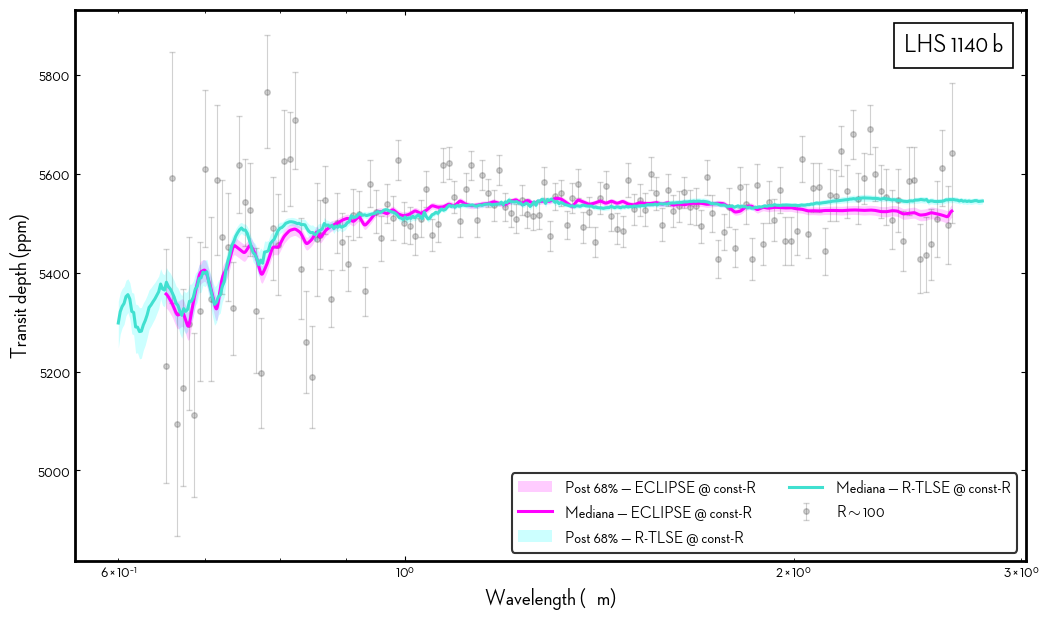

[OK] Figura salva em: LHS1140b_compare_R100_ECLIPSE_constR_sem_R20points.png


In [6]:
# -*- coding: utf-8 -*-
"""
Comparativo: R~100 (Cadieux+ NIRISS) × banda/mediana ECLIPSE (R≈const)
- Remove o plot dos pontos R~20 (stack_data_ECLIPSE.txt) — conforme pedido.
- Corrige dataset dos modelos ECLIPSE para 'R20_constR20' por padrão.
- Auto-fallback: se 'R20_constR20' não existir, escolhe automaticamente
  o primeiro dataset que combine 'R20_constR...'.
- Bloco R-TLSE continua opcional (apenas se o arquivo existir).
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

# ---------------- Paths ----------------
p_r100 = Path("apjlad5afat2_mrt.txt")                 # Cadieux+ tabela MRT
p_stack_models_eclipse = Path("stack_models_ECLIPSE.txt")
p_stack_models_tlse    = Path("stack_models_R-TLSE.txt")  # opcional

# ---------------- Paleta ----------------
ROSE      = "magenta"
BLUE_LINE = "turquoise"
BLUE_BAND = "cyan"

# ---------------- Helpers ----------------
def read_r100_with_sigma(path: Path):
    """Lê apjlad5afat2_mrt.txt e retorna (lam_um, depth_ppm, sigma_ppm) para o planeta b."""
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if (not s) or s.startswith("#") or s.lower().startswith(("title","table","note","column","byte","---")):
                continue
            parts = s.replace(",", " ").split()
            # esperamos ao menos: CWave  Width  Depth-b  e_Depth-b ...
            try:
                vals = list(map(float, parts))
            except Exception:
                continue
            if len(vals) >= 4:
                rows.append(vals)
    if not rows:
        return np.array([]), np.array([]), np.array([])
    arr = np.array(rows, float)
    lam_um    = arr[:, 0]
    depth_ppm = arr[:, 2]
    sigma_ppm = arr[:, 3]
    order = np.argsort(lam_um)
    return lam_um[order], depth_ppm[order], sigma_ppm[order]

def _dedup_lambda_mean(lam, *cols):
    """Desduplica por λ fazendo média; retorna λ ordenado e colunas na mesma ordem."""
    df = pd.DataFrame({"lam": lam})
    for i, c in enumerate(cols):
        df[f"c{i}"] = c
    df2 = df.groupby("lam", as_index=False).mean(numeric_only=True)
    df2 = df2.sort_values("lam")
    outs = [df2["lam"].to_numpy(float)]
    for i in range(len(cols)):
        outs.append(df2[f"c{i}"].to_numpy(float))
    return tuple(outs)

def auto_pick_eclipse_dataset(df_models: pd.DataFrame, preferred="R20_constR20"):
    """Escolhe dataset de modelos ECLIPSE."""
    ds_all = sorted(set(df_models.get("dataset", [])))
    if preferred in ds_all:
        return preferred
    # fallback: algo que comece com 'R20_constR'
    cand = [d for d in ds_all if str(d).startswith("R20_constR")]
    if cand:
        return cand[0]
    # último recurso: primeiro dataset existente
    if ds_all:
        return ds_all[0]
    raise RuntimeError("Nenhum dataset disponível em stack_models_ECLIPSE.txt")

def read_model_band_filter(path: Path, dataset_key=None, method_contains=None):
    """Lê banda/mediana do arquivo de modelos (ECLIPSE ou TLSE)."""
    if not path.exists():
        raise FileNotFoundError(f"Arquivo não encontrado: {path}")
    df = pd.read_csv(path, sep="\t")
    if dataset_key is None:
        # auto-escolha para ECLIPSE
        dataset_key = auto_pick_eclipse_dataset(df, preferred="R20_constR20")
        print(f"[INFO] dataset ECLIPSE selecionado: {dataset_key}")
    df = df.loc[df["dataset"] == dataset_key].copy()

    if method_contains is not None and "method" in df.columns:
        df = df.loc[df["method"].astype(str).str.contains(method_contains, na=False)]

    if df.empty:
        opts_ds = sorted(set(df["dataset"])) if "dataset" in df.columns else []
        opts_mt = sorted(set(df["method"]))  if "method"  in df.columns else []
        raise RuntimeError(
            f"Nenhuma linha após filtros em {path}\n"
            f"  dataset pedido: {dataset_key!r}\n"
            f"  método contém : {method_contains!r}\n"
            f"  datasets disp.: {opts_ds}\n"
            f"  methods disp. : {opts_mt[:8]}{' ...' if len(opts_mt)>8 else ''}"
        )

    lam_col = "lam_um" if "lam_um" in df.columns else "lambda_um"
    med_col = "med_ppm" if "med_ppm" in df.columns else "median_ppm"

    lam = df[lam_col].to_numpy(float)
    med = df[med_col].to_numpy(float)
    lo  = df["lo_ppm"].to_numpy(float)
    hi  = df["hi_ppm"].to_numpy(float)

    return _dedup_lambda_mean(lam, med, lo, hi)

def fill_band(ax, x, lo, hi, *, color, alpha=0.2, label=None, zorder=1):
    x  = np.asarray(x, float)
    lo = np.asarray(lo, float)
    hi = np.asarray(hi, float)
    if x.size < 3:
        return
    lo2 = np.minimum(lo, hi)
    hi2 = np.maximum(lo, hi)
    good = np.isfinite(x) & np.isfinite(lo2) & np.isfinite(hi2)
    x, lo2, hi2 = x[good], lo2[good], hi2[good]
    if x.size < 3:
        return
    ax.fill_between(x, lo2, hi2, color=color, alpha=alpha, linewidth=0,
                    label=label, zorder=zorder)

# ---------------- Carrega dados ----------------
lam_r100, y_r100, sig_r100 = read_r100_with_sigma(p_r100)

# Modelos ECLIPSE (R≈const) — tenta 'R20_constR20' primeiro; caso não exista, faz fallback.
lam_ecl, med_ecl, lo_ecl, hi_ecl = read_model_band_filter(
    p_stack_models_eclipse,
    dataset_key=None,          # None => auto-pick com preferência por 'R20_constR20'
    method_contains=None
)

# R-TLSE (opcional)
have_tlse = p_stack_models_tlse.exists()
if have_tlse:
    lam_tlse, med_tlse, lo_tlse, hi_tlse = read_model_band_filter(
        p_stack_models_tlse,
        dataset_key=None,                # geralmente TLSE não usa 'dataset', só 'method'
        method_contains="@constR"        # ajuste se precisar filtrar outro método
    )

# ---------------- Plot ----------------
fig, ax = plt.subplots(figsize=(10.6, 6.3))

# R~100 (pontos com σ)
if lam_r100.size:
    ax.errorbar(lam_r100, y_r100, yerr=sig_r100, fmt='o', ms=4.0, color='black',
                alpha=0.18, capsize=2.5, elinewidth=0.8, label=r'R$\sim$100')

# Banda/mediana ECLIPSE
fill_band(ax, lam_ecl, lo_ecl, hi_ecl, color=ROSE, alpha=0.20,
          label='Post 68% — ECLIPSE @ const-R')
ax.plot(lam_ecl, med_ecl, color=ROSE, lw=2.2, label='Mediana — ECLIPSE @ const-R', zorder=4)

# R-TLSE @ const-R (se existir)
if have_tlse:
    fill_band(ax, lam_tlse, lo_tlse, hi_tlse, color=BLUE_BAND, alpha=0.20,
              label='Post 68% — R-TLSE @ const-R', zorder=1)
    ax.plot(lam_tlse, med_tlse, color=BLUE_LINE, lw=2.2, label='Mediana — R-TLSE @ const-R', zorder=4)

# Eixos, labels e legendas
ax.set_xscale('log')
ax.set_xlabel('Wavelength (µm)', fontsize=16)
ax.set_ylabel('Transit depth (ppm)', fontsize=16)

leg = ax.legend(loc='best', fontsize=12, ncol=2, frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.5)
leg.get_frame().set_facecolor('white')

at = AnchoredText("LHS 1140 b", loc='upper right',
                  prop=dict(size=18, color='black'), frameon=True)
at.patch.set_facecolor('white')
at.patch.set_edgecolor('black')
at.patch.set_linewidth(1.2)
ax.add_artist(at)

ax.tick_params(axis="both", which="both", labelsize=12,
               direction="in", top=True, right=True)
plt.tight_layout()

out_png = "LHS1140b_compare_R100_ECLIPSE_constR_sem_R20points.png"
plt.savefig(out_png, dpi=240)
plt.show()
print(f"[OK] Figura salva em: {out_png}")


[INFO] dataset selecionado: MRT_constR200
[INFO] dataset selecionado: MRT_constR200
[INFO] dataset selecionado: R20


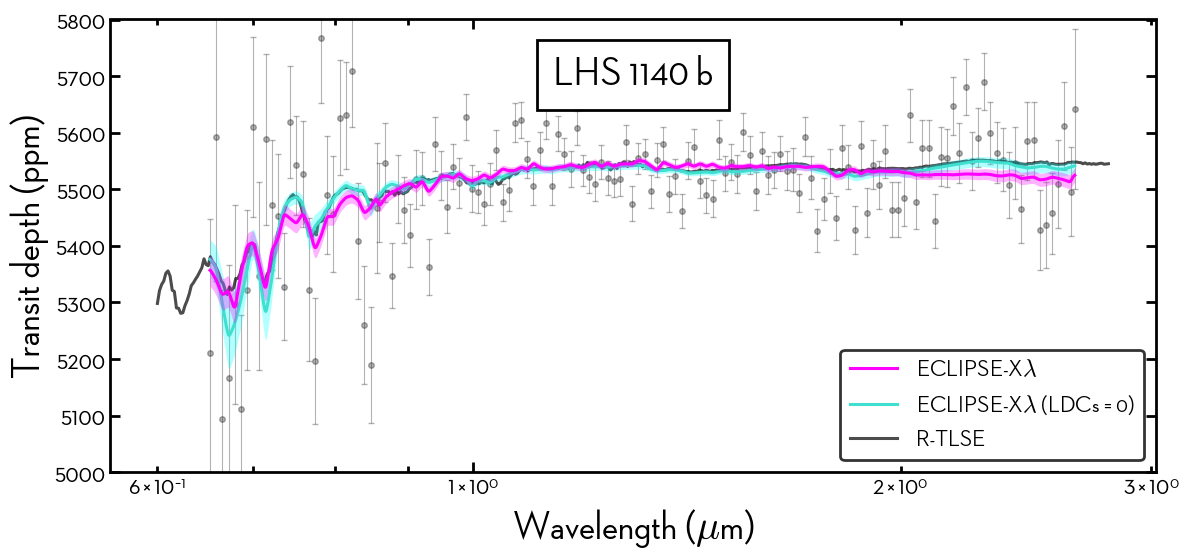

In [7]:
# -*- coding: utf-8 -*-
"""
Comparativo final solicitado:
- Curva preta contínua (R-TLSE)
- Curva rosa contínua (ECLIPSE-Xλ)
- Curva azul contínua (ECLIPSE-Xλ (LDCs=0))
- Mantém dados observacionais (R~100, Cadieux+ NIRISS)
- Ordem de camadas: pontos (fundo) < R-TLSE (preto) < ECLIPSE-Xλ LDCs=0 (azul) < ECLIPSE-Xλ (rosa)
- Post 68% para ECLIPSE-Xλ (rosa) e ECLIPSE-Xλ (LDCs=0) (azul)
- Sem mudanças nas configurações de estilo/axes/ticks, conforme pedido.
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib import rcParams
import os
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter, LogLocator

plt.rcParams['axes.linewidth'] = 2

# Configurar cache da fonte (remover se necessário)
font_cache_dir = os.path.join(mpl.get_cachedir(), 'fontList.json')
if os.path.exists(font_cache_dir):
    os.remove(font_cache_dir)

# Definir o caminho para a fonte personalizada
diretorio_dados = "C:\\Users\\vikto\\OneDrive\\PhD_Mackenzie\\Small Radius Planets"
font_path = os.path.join(diretorio_dados, "Neutraface2Display-Medium.otf")
fm.fontManager.addfont(font_path)
neutra_face = fm.FontProperties(fname=font_path).get_name()

# Configurações globais de fonte
plt.rcParams['font.family']         = 'sans-serif'
plt.rcParams['font.sans-serif']     = [neutra_face]
plt.rcParams['mathtext.fontset']    = 'custom'
plt.rcParams['mathtext.rm']         = neutra_face
plt.rcParams['mathtext.it']         = f'{neutra_face}:italic'
plt.rcParams['mathtext.bf']         = f'{neutra_face}:bold'

# ---------------- Paths ----------------
p_r100 = Path("apjlad5afat2_mrt.txt")                 # Cadieux+ tabela MRT (dados observacionais)
p_stack_models_eclipse = Path("stack_models_ECLIPSE.txt")          # ECLIPSE-Xλ (rosa)
p_stack_models_eclipse_ldc0 = Path("C:\\Users\\vikto\\OneDrive\\ECLIPSE-Xlambda\\ECLIPSE-Xlambda - LHS 1140 b\\LDC_0_stack_models_ECLIPSE.txt")  # ECLIPSE-Xλ (LDCs=0) [ANEXO]
p_stack_models_tlse    = Path("stack_models_R-TLSE.txt")           # R-TLSE (preto)

# ---------------- Paleta ----------------
ROSE      = "magenta"    # ECLIPSE-Xλ
BLUE_LINE = "turquoise"  # ECLIPSE-Xλ (LDCs=0) - linha
BLUE_BAND = "cyan"       # ECLIPSE-Xλ (LDCs=0) - banda

# ---------------- Helpers ----------------
def read_r100_with_sigma(path: Path):
    """Lê apjlad5afat2_mrt.txt e retorna (lam_um, depth_ppm, sigma_ppm) para o planeta b."""
    rows = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if (not s) or s.startswith("#") or s.lower().startswith(("title","table","note","column","byte","---")):
                continue
            parts = s.replace(",", " ").split()
            # esperamos ao menos: CWave  Width  Depth-b  e_Depth-b ...
            try:
                vals = list(map(float, parts))
            except Exception:
                continue
            if len(vals) >= 4:
                rows.append(vals)
    if not rows:
        return np.array([]), np.array([]), np.array([])
    arr = np.array(rows, float)
    lam_um    = arr[:, 0]
    depth_ppm = arr[:, 2]
    sigma_ppm = arr[:, 3]
    order = np.argsort(lam_um)
    return lam_um[order], depth_ppm[order], sigma_ppm[order]

def _dedup_lambda_mean(lam, *cols):
    """Desduplica por λ fazendo média; retorna λ ordenado e colunas na mesma ordem."""
    df = pd.DataFrame({"lam": lam})
    for i, c in enumerate(cols):
        df[f"c{i}"] = c
    df2 = df.groupby("lam", as_index=False).mean(numeric_only=True)
    df2 = df2.sort_values("lam")
    outs = [df2["lam"].to_numpy(float)]
    for i in range(len(cols)):
        outs.append(df2[f"c{i}"].to_numpy(float))
    return tuple(outs)

def auto_pick_eclipse_dataset(df_models: pd.DataFrame, preferred="R20_constR20"):
    """Escolhe dataset de modelos ECLIPSE."""
    ds_all = sorted(set(df_models.get("dataset", [])))
    if preferred in ds_all:
        return preferred
    # fallback: algo que comece com 'R20_constR'
    cand = [d for d in ds_all if str(d).startswith("R20_constR")]
    if cand:
        return cand[0]
    # último recurso: primeiro dataset existente
    if ds_all:
        return ds_all[0]
    raise RuntimeError("Nenhum dataset disponível no arquivo de modelos.")

def read_model_band_filter(path: Path, dataset_key=None, method_contains=None):
    """Lê banda/mediana do arquivo de modelos (ECLIPSE ou TLSE)."""
    if not path.exists():
        raise FileNotFoundError(f"Arquivo não encontrado: {path}")
    df = pd.read_csv(path, sep="\t")
    if dataset_key is None:
        # auto-escolha (preferência por 'R20_constR20' quando existir)
        dataset_key = auto_pick_eclipse_dataset(df, preferred="R20_constR20")
        print(f"[INFO] dataset selecionado: {dataset_key}")
    df = df.loc[df["dataset"] == dataset_key].copy()

    if method_contains is not None and "method" in df.columns:
        df = df.loc[df["method"].astype(str).str.contains(method_contains, na=False)]

    if df.empty:
        opts_ds = sorted(set(df["dataset"])) if "dataset" in df.columns else []
        opts_mt = sorted(set(df["method"]))  if "method"  in df.columns else []
        raise RuntimeError(
            f"Nenhuma linha após filtros em {path}\n"
            f"  dataset pedido: {dataset_key!r}\n"
            f"  método contém : {method_contains!r}\n"
            f"  datasets disp.: {opts_ds}\n"
            f"  methods disp. : {opts_mt[:8]}{' ...' if len(opts_mt)>8 else ''}"
        )

    lam_col = "lam_um" if "lam_um" in df.columns else "lambda_um"
    med_col = "med_ppm" if "med_ppm" in df.columns else "median_ppm"

    lam = df[lam_col].to_numpy(float)
    med = df[med_col].to_numpy(float)
    lo  = df["lo_ppm"].to_numpy(float)
    hi  = df["hi_ppm"].to_numpy(float)

    return _dedup_lambda_mean(lam, med, lo, hi)

def fill_band(ax, x, lo, hi, *, color, alpha=0.2, label=None, zorder=1):
    x  = np.asarray(x, float)
    lo = np.asarray(lo, float)
    hi = np.asarray(hi, float)
    if x.size < 3:
        return
    lo2 = np.minimum(lo, hi)
    hi2 = np.maximum(lo, hi)
    good = np.isfinite(x) & np.isfinite(lo2) & np.isfinite(hi2)
    x, lo2, hi2 = x[good], lo2[good], hi2[good]
    if x.size < 3:
        return
    ax.fill_between(x, lo2, hi2, color=color, alpha=alpha, linewidth=0,
                    label=label, zorder=zorder)

# ---------------- Carrega dados ----------------
lam_r100, y_r100, sig_r100 = read_r100_with_sigma(p_r100)

# ECLIPSE-Xλ (rosa) — método Xλ; dataset auto-pick (pref. 'R20_constR20' quando existir)
lam_ecl, med_ecl, lo_ecl, hi_ecl = read_model_band_filter(
    p_stack_models_eclipse,
    dataset_key=None,
    method_contains="ECLIPSE-X"    # garante filtrar o método Xλ
)

# ECLIPSE-Xλ (LDCs=0) — azul; arquivo anexado; dataset será auto-escolhido (MRT_constR200 nos anexos)
lam_ecl0, med_ecl0, lo_ecl0, hi_ecl0 = read_model_band_filter(
    p_stack_models_eclipse_ldc0,
    dataset_key=None,              # auto-pick -> deve cair em 'MRT_constR200' nos anexos
    method_contains="ECLIPSE-X"
)

# R-TLSE (preto) — só curva (mediana)
have_tlse = p_stack_models_tlse.exists()
if have_tlse:
    lam_tlse, med_tlse, lo_tlse, hi_tlse = read_model_band_filter(
        p_stack_models_tlse,
        dataset_key=None,
        method_contains=None
    )

# ---------------- Plot ----------------
fig, ax = plt.subplots(figsize=(12, 5.7))

# Dados observacionais R~100 (pontos) — zorder mais baixo
if lam_r100.size:
    ax.errorbar(lam_r100, y_r100, yerr=sig_r100, fmt='o', ms=4.0, color='black',
                alpha=0.3, capsize=2.5, elinewidth=0.8, label=None, zorder=1)

# Curva preta contínua: R-TLSE (na frente dos dados, atrás do azul e rosa)
if have_tlse:
    ax.plot(lam_tlse, med_tlse, color='black', lw=2.2, label=r'R-TLSE', alpha=0.7, zorder=2)

# ECLIPSE-Xλ (LDCs=0) — banda 68% + curva azul (na frente do preto, atrás do rosa)
fill_band(ax, lam_ecl0, lo_ecl0, hi_ecl0, color=BLUE_BAND, alpha=0.30,
          label=None, zorder=3.0)
ax.plot(lam_ecl0, med_ecl0, color=BLUE_LINE, lw=2.2,
        label=r'ECLIPSE-X$\lambda$ (LDCs = 0)', zorder=3.5)

# ECLIPSE-Xλ — banda 68% + curva rosa (na frente do azul)
fill_band(ax, lam_ecl, lo_ecl, hi_ecl, color=ROSE, alpha=0.30,
          label=None, zorder=4.0)
ax.plot(lam_ecl, med_ecl, color=ROSE, lw=2.2,
        label=r'ECLIPSE-X$\lambda$', zorder=5.0)

# Eixos, labels e legendas (inalterados)
ax.set_xscale('log', base=10)
ax.xaxis.set_major_locator(LogLocator(base=10))

def fmt(x, pos):
    e = int(np.round(np.log10(x)))
    if np.isclose(x, 1.0):                 # o 10^0
        return r'$1\times10^{0}$'
    return rf'$10^{{{e}}}$'                # 10^{e} para os demais
    # se quiser sempre "1×10^{e}":
    # return rf'$1\times10^{{{e}}}$'

ax.xaxis.set_major_formatter(FuncFormatter(fmt))

ax.set_xlabel(r'Wavelength ($\mathrm{\mu m}$)', fontsize=29)
ax.set_ylabel('Transit depth (ppm)', fontsize=29)

# --- Legenda (apenas reordenada: rosa, azul, preto) ---
handles, labels = ax.get_legend_handles_labels()

# ordem desejada
ordem = [
    labels.index(r'ECLIPSE-X$\lambda$'),                 # rosa
    labels.index(r'ECLIPSE-X$\lambda$ (LDCs = 0)'),        # azul
    labels.index('R-TLSE')                               # preto
]

leg = ax.legend([handles[i] for i in ordem],
                [labels[i] for i in ordem],
                loc='lower right', fontsize=17, ncol=1, frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(2)
leg.get_frame().set_facecolor('white')

at = AnchoredText("LHS 1140 b", loc='upper center',
                  prop=dict(size=29, color='black'), frameon=True)
at.patch.set_facecolor('white')
at.patch.set_edgecolor('black')
at.patch.set_linewidth(2)
ax.add_artist(at)

tick_kw    = dict(direction='in', top=True, right=True, labelsize=19, width=2, pad=3)
ax.tick_params(axis='x', which='major', **{**tick_kw, 'length':7})
ax.tick_params(axis='x', which='minor', **{**tick_kw, 'length':4})
ax.tick_params(axis='y', which='major', **{**tick_kw, 'length':7})
ax.tick_params(axis='y', which='minor', **{**tick_kw, 'length':4})

ax.set_ylim(5000, 5800)

plt.tight_layout()

plt.savefig("Paper Figures\\LHS1140b_transmission_spectrum.svg", format="svg")
plt.show()


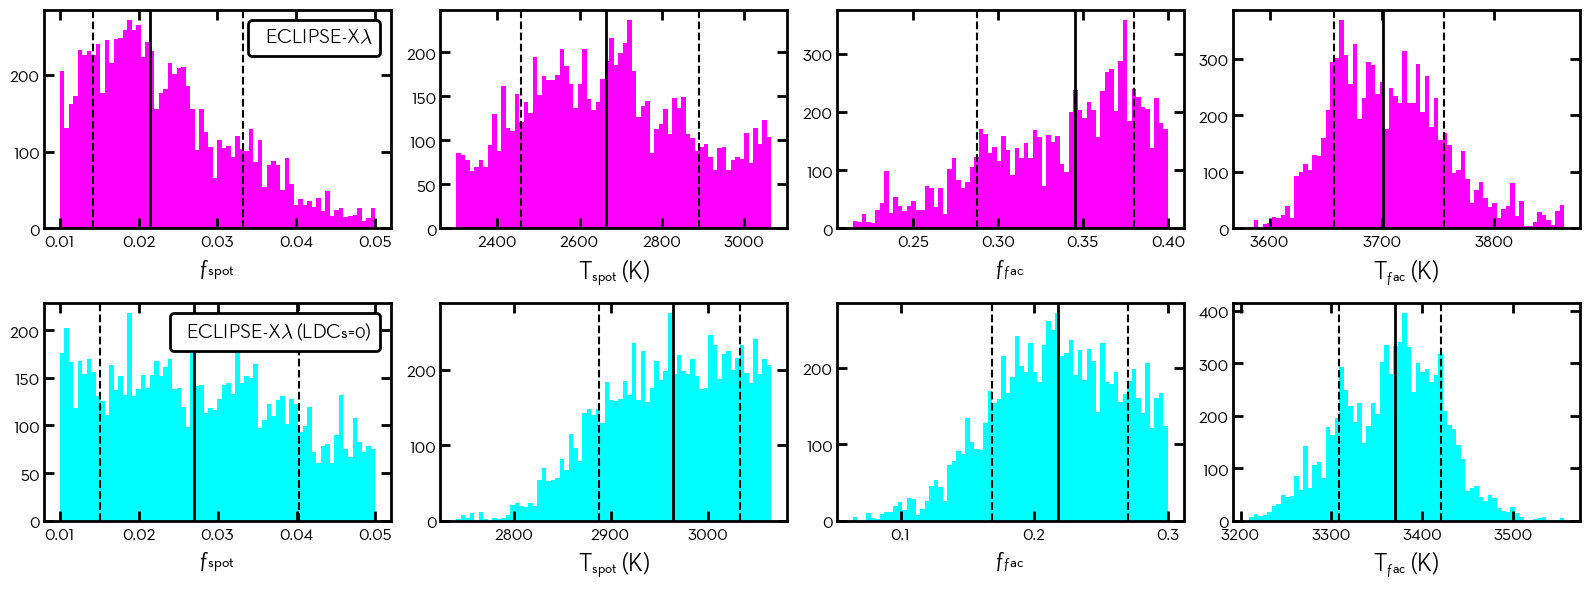

In [8]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

p_chain_norm   = Path("stack_chain_ECLIPSE.txt")
p_chain_ldc0   = Path("LDC_0_stack_chain_ECLIPSE.txt")
p_params_norm  = Path("stack_params_ECLIPSE.txt")           # fallback
p_params_ldc0  = Path("LDC_0_stack_params_ECLIPSE.txt")     # fallback

def _load_chain_or_fallback(chain_path: Path, params_path: Path):
    if chain_path.exists():
        df = pd.read_csv(chain_path, sep="\t")
        need = ["f_spot","T_spot","f_fac","T_fac"]
        if not set(need).issubset(df.columns):
            raise RuntimeError(f"Chain sem colunas necessárias: {chain_path}")
        return (df["f_spot"].to_numpy(float),
                df["T_spot"].to_numpy(float),
                df["f_fac"].to_numpy(float),
                df["T_fac"].to_numpy(float)), True

    # Fallback via p16/p50/p84 (para não quebrar)
    if not params_path.exists():
        raise FileNotFoundError(f"Nem chain nem params encontrados para {chain_path}")
    df = pd.read_csv(params_path, sep="\t")
    out = []
    rng = np.random.default_rng(123)
    for prefix in ["f_spot","T_spot","f_fac","T_fac"]:
        p50 = float(df[f"{prefix}_p50"].iloc[0])
        p16 = float(df[f"{prefix}_16"].iloc[0] if f"{prefix}_16" in df.columns else df[f"{prefix}_p16"].iloc[0])
        p84 = float(df[f"{prefix}_84"].iloc[0] if f"{prefix}_84" in df.columns else df[f"{prefix}_p84"].iloc[0])
        sigma = max(1e-12, 0.5*(p84 - p16))
        s = rng.normal(p50, sigma, size=16000)
        if prefix.startswith("f_"):
            s = s[s > 0]
        out.append(s)
    return tuple(out), False

def _add_cred_lines(ax, samples, color="k"):
    """
    Desenha mediana (linha cheia) e intervalos 16–84% (linhas tracejadas)
    para um conjunto de amostras 1D.
    """
    samples = np.asarray(samples, float)
    q16, q50, q84 = np.percentile(samples, [16, 50, 84])
    ax.axvline(q50, color=color, linestyle="-", linewidth=2)
    ax.axvline(q16, color=color, linestyle="--", linewidth=1.5)
    ax.axvline(q84, color=color, linestyle="--", linewidth=1.5)

def _add_text_box_legend(ax, text, loc="upper right", fontsize=15):
    """
    Cria uma legenda com texto dentro da caixa, sem linha/símbolo na frente.
    """
    dummy = Line2D([], [], linestyle="None")  # handle invisível
    leg = ax.legend([dummy], [text],
                    frameon=True, fontsize=fontsize,
                    handlelength=0, handletextpad=0.4, loc=loc)
    frame = leg.get_frame()
    frame.set_edgecolor('black')
    frame.set_linewidth(2)
    frame.set_facecolor('white')
    frame.set_alpha(1.0)
    return leg

# carrega cadeias
(norm, ok_norm) = _load_chain_or_fallback(p_chain_norm, p_params_norm)
(ldc0, ok_ldc0) = _load_chain_or_fallback(p_chain_ldc0, p_params_ldc0)
f_spot_n, T_spot_n, f_fac_n, T_fac_n = norm
f_spot_0, T_spot_0, f_fac_0, T_fac_0 = ldc0

# plot 2×4
fig, axs = plt.subplots(2, 4, figsize=(16, 6), sharey=False)

# ----------------- linha de cima — normal (magenta) -----------------
axs[0,0].hist(f_spot_n, bins=70, alpha=1, color="magenta")
_add_cred_lines(axs[0,0], f_spot_n)
axs[0,0].set_xlabel('ƒ$_{\\mathrm{spot}}$', fontsize=19)
_add_text_box_legend(axs[0,0], r"ECLIPSE-X$\lambda$", loc="upper right", fontsize=15)

axs[0,1].hist(T_spot_n, bins=70, alpha=1, color="magenta")
_add_cred_lines(axs[0,1], T_spot_n)
axs[0,1].set_xlabel("T$_\\mathrm{spot}$ (K)", fontsize=18)

axs[0,2].hist(f_fac_n, bins=70, alpha=1, color="magenta")
_add_cred_lines(axs[0,2], f_fac_n)
axs[0,2].set_xlabel("ƒ$_\\mathrm{ƒac}$", fontsize=19)

axs[0,3].hist(T_fac_n, bins=70, alpha=1, color="magenta")
_add_cred_lines(axs[0,3], T_fac_n)
axs[0,3].set_xlabel("T$_\\mathrm{ƒac}$ (K)", fontsize=18)

# ----------------- linha de baixo — LDCs=0 (cyan) -----------------
axs[1,0].hist(f_spot_0, bins=70, alpha=1, color="cyan")
_add_cred_lines(axs[1,0], f_spot_0)
axs[1,0].set_xlabel("ƒ$_\\mathrm{spot}$", fontsize=19)
_add_text_box_legend(axs[1,0], r"ECLIPSE-X$\lambda$ (LDCs=0)", loc="upper right", fontsize=15)

axs[1,1].hist(T_spot_0, bins=70, alpha=1, color="cyan")
_add_cred_lines(axs[1,1], T_spot_0)
axs[1,1].set_xlabel("T$_\\mathrm{spot}$ (K)", fontsize=18)

axs[1,2].hist(f_fac_0, bins=70, alpha=1, color="cyan")
_add_cred_lines(axs[1,2], f_fac_0)
axs[1,2].set_xlabel("ƒ$_\\mathrm{ƒac}$", fontsize=19)

axs[1,3].hist(T_fac_0, bins=70, alpha=1, color="cyan")
_add_cred_lines(axs[1,3], T_fac_0)
axs[1,3].set_xlabel("T$_\\mathrm{ƒac}$ (K)", fontsize=18)

# ---------- ticks estilo "paper" ----------
tick_kw = dict(direction='in', top=True, right=True, labelsize=15, width=2, pad=3)
for ax in axs.ravel():
    ax.tick_params(axis='x', which='major', **{**tick_kw, 'length':7})
    ax.tick_params(axis='x', which='minor', **{**tick_kw, 'length':4})
    ax.tick_params(axis='y', which='major', **{**tick_kw, 'length':7})
    ax.tick_params(axis='y', which='minor', **{**tick_kw, 'length':4})

plt.tight_layout()
plt.savefig("Paper Figures\\LHS1140b_posteriors.svg", format="svg")
plt.show()

if not ok_norm or not ok_ldc0:
    print("[AVISO] Um dos conjuntos veio de p16/p50/p84 (aproximação). Rode o MCMC exportando as cadeias para histogramas reais.")

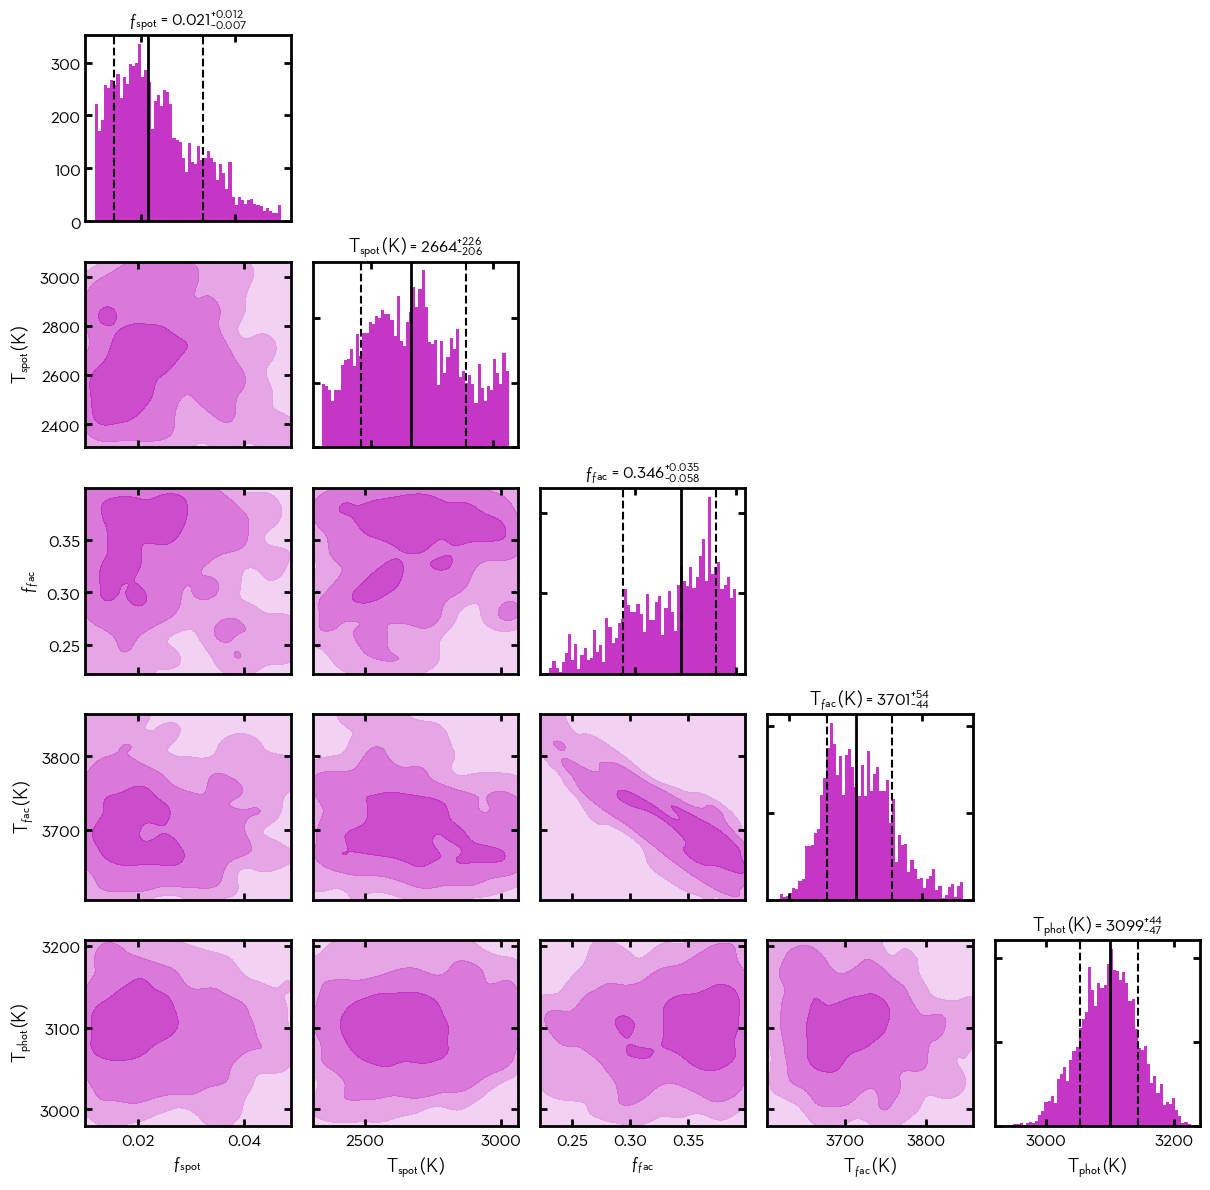

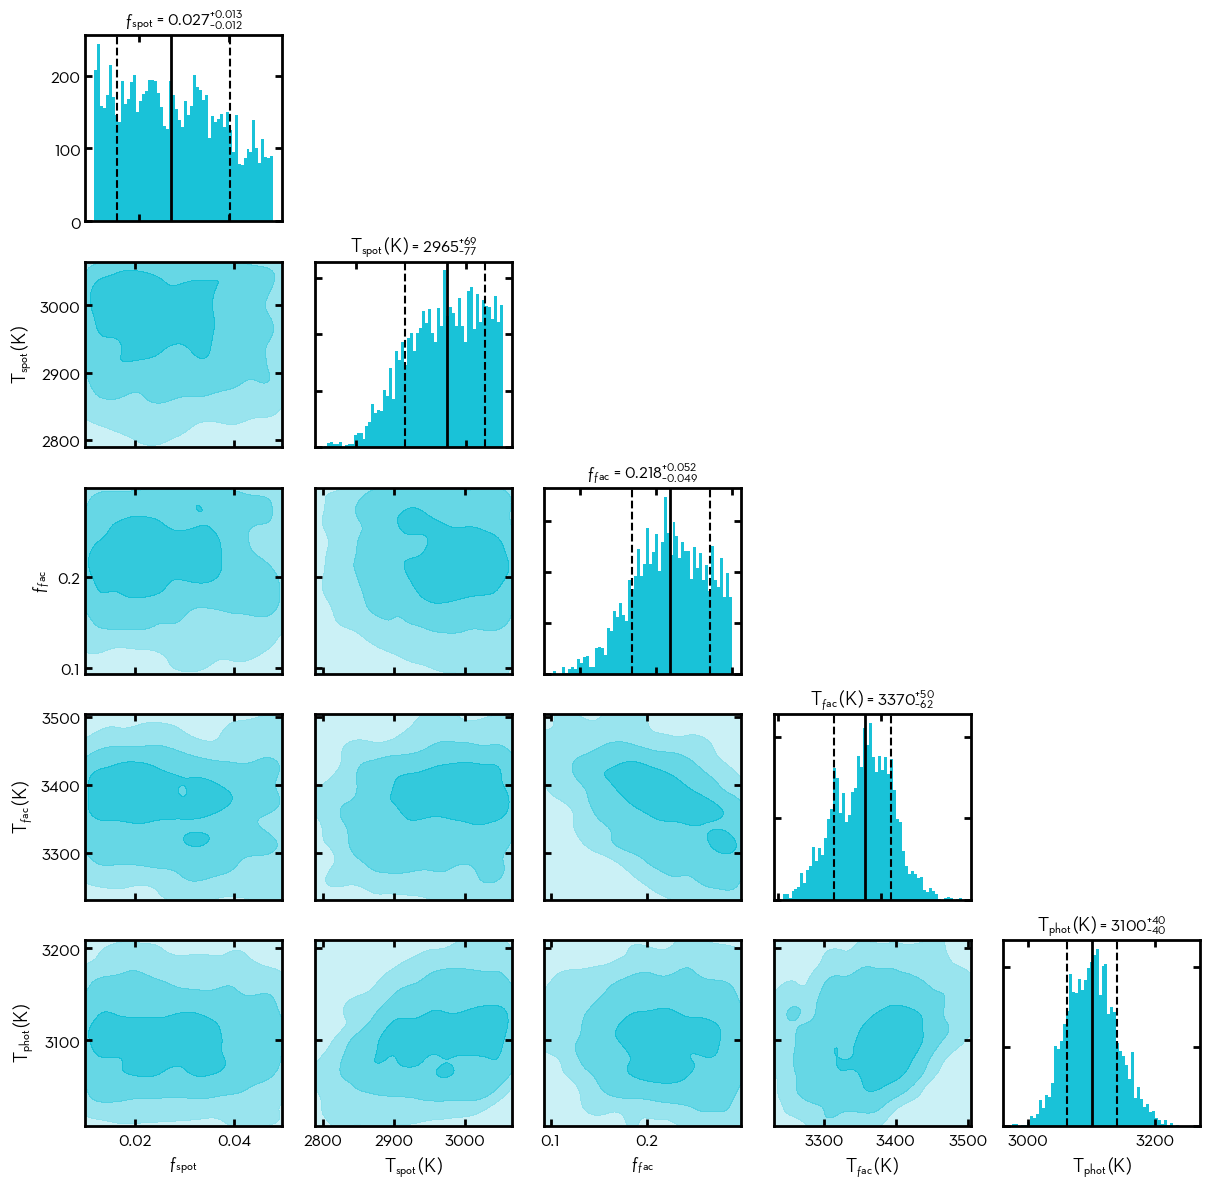

In [10]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from pathlib import Path

try:
    from scipy.stats import gaussian_kde
except Exception:
    gaussian_kde = None

try:
    from scipy.ndimage import gaussian_filter
except Exception:
    gaussian_filter = None

# =======================
# Arquivos de entrada
# =======================
p_chain_norm   = Path("stack_chain_ECLIPSE.txt")
p_chain_ldc0   = Path("LDC_0_stack_chain_ECLIPSE.txt")
p_params_norm  = Path("stack_params_ECLIPSE.txt")           # fallback
p_params_ldc0  = Path("LDC_0_stack_params_ECLIPSE.txt")     # fallback

# =======================
# Utilidades de IO
# =======================
def load_chain_or_fallback(chain_path: Path, params_path: Path,
                           want_cols=("f_spot","T_spot","f_fac","T_fac","T_phot")):
    """
    Retorna (cols, X, ok_chain)
      - cols: lista de nomes de colunas carregadas
      - X: array [N, D] com draws
      - ok_chain: True se veio de chain real; False se foi fallback de quantis
    """
    if chain_path.exists():
        df = pd.read_csv(chain_path, sep="\t")
        cols = [c for c in want_cols if c in df.columns]
        if not cols:
            raise RuntimeError(f"Cadeia sem colunas esperadas: {chain_path}")
        X = np.column_stack([pd.to_numeric(df[c], errors="coerce").to_numpy(float) for c in cols])
        m = np.all(np.isfinite(X), axis=1)
        return cols, X[m], True

    # Fallback a partir de p16/p50/p84 (apenas para não quebrar)
    if not params_path.exists():
        raise FileNotFoundError(f"Nem chain nem params encontrados para {chain_path}")
    df = pd.read_csv(params_path, sep="\t")
    rng = np.random.default_rng(123)
    cols = []
    draws = []
    for c in want_cols:
        c16 = c+"_p16" if c+"_p16" in df.columns else (c+"_16" if c+"_16" in df.columns else None)
        c50 = c+"_p50" if c+"_p50" in df.columns else (c if c in df.columns else None)
        c84 = c+"_p84" if c+"_p84" in df.columns else (c+"_84" if c+"_84" in df.columns else None)
        if c50 is None:
            continue
        cols.append(c)
        if c16 is not None and c84 is not None:
            p16 = float(df[c16].iloc[0]); p50 = float(df[c50].iloc[0]); p84 = float(df[c84].iloc[0])
            sig = max(1e-12, 0.5*(p84 - p16))
            s = rng.normal(p50, sig, size=20000)
        else:
            s = pd.to_numeric(df[c50], errors="coerce").dropna().to_numpy(float)
        if c.startswith("f_"):
            s = s[(s >= 0) & np.isfinite(s)]
        draws.append(s[:20000])
    n = min(len(s) for s in draws)
    X = np.column_stack([s[:n] for s in draws])
    return cols, X, False

# =======================
# Densidade 2D e níveis 1–2–3σ
# =======================
def density_2d(x, y, nbins=150):
    x = np.asarray(x, float); y = np.asarray(y, float)
    xlo, xhi = np.nanpercentile(x, [0.5, 99.5])
    ylo, yhi = np.nanpercentile(y, [0.5, 99.5])
    if not np.isfinite(xlo): xlo = np.nanmin(x)
    if not np.isfinite(xhi): xhi = np.nanmax(x)
    if not np.isfinite(ylo): ylo = np.nanmin(y)
    if not np.isfinite(yhi): yhi = np.nanmax(y)

    Xg = np.linspace(xlo, xhi, nbins)
    Yg = np.linspace(ylo, yhi, nbins)
    XX, YY = np.meshgrid(Xg, Yg, indexing="xy")

    if gaussian_kde is not None and np.isfinite(x).sum() > 100:
        kde = gaussian_kde(np.vstack([x, y]))
        ZZ = kde(np.vstack([XX.ravel(), YY.ravel()])).reshape(XX.shape)
        ZZ = ZZ / ZZ.sum()
        return Xg, Yg, ZZ

    H, _, _ = np.histogram2d(x, y, bins=nbins, range=[[xlo,xhi],[ylo,yhi]])
    H = H.T
    if gaussian_filter is not None:
        H = gaussian_filter(H, sigma=1.2, mode="nearest")
    H = H / max(H.sum(), 1.0)
    return Xg, Yg, H

def sigma_levels(pdf2d):
    flat = np.sort(pdf2d.ravel())[::-1]
    cdf  = np.cumsum(flat)
    probs = [0.393, 0.865, 0.989]   # ~1,2,3σ
    levels = []
    for p in probs:
        idx = np.searchsorted(cdf, p)
        lvl = flat[idx] if idx < flat.size else flat[-1]
        levels.append(lvl)
    return levels[::-1]

# =======================
# 1D: mediana + 16/84 em preto
# =======================
def add_cred_lines(ax, samples, color="k"):
    samples = np.asarray(samples, float)
    q16, q50, q84 = np.percentile(samples, [16, 50, 84])
    ax.axvline(q50, color=color, linestyle="-", linewidth=2)
    ax.axvline(q16, color=color, linestyle="--", linewidth=1.5)
    ax.axvline(q84, color=color, linestyle="--", linewidth=1.5)
    return q16, q50, q84

# =======================
# Gerar degradê a partir de uma cor base
# =======================
def color_family(base_color, n=4):
    base = np.array(to_rgb(base_color))
    colors = []
    alphas = np.linspace(0.25, 1.0, n)   # 0.25 bem clarinho → 1.0 cor cheia
    for a in alphas:
        c = (1.0 - a) * np.ones(3) + a * base
        colors.append(c)
    return colors

# =======================
# Corner com preenchimento em degradê (sem linhas de contorno)
# =======================
def corner_contours(cols, X, color="#c020c0", bins_1d=60):
    D = len(cols)
    fig, axes = plt.subplots(D, D, figsize=(2.2*D+1.2, 2.2*D+1.0))
    if D == 1:
        axes = np.array([[axes]])

    label_map = {
        "f_spot":  r"ƒ$_{\rm spot}$",
        "f_fac":   r"ƒ$_{\rm ƒac}$",
        "T_spot":  r"$T_{\rm spot}\,(\mathrm{K})$",
        "T_fac":   r"$T_{\rm ƒac}\,(\mathrm{K})$",
        "T_phot":  r"$T_{\rm phot}\,(\mathrm{K})$",
    }
    labels = [label_map.get(c, c) for c in cols]

    fill_colors = color_family(color, n=4)   # 4 bandas de cor

    for ax in axes.ravel():
        ax.tick_params(axis='both', which='both',
                       direction='in', top=True, right=True, length=5, width=2, labelsize=15)

    for i in range(D):
        for j in range(D):
            ax = axes[i, j]
            if i < j:
                ax.axis("off")
                continue

            x = X[:, j]
            if i == j:
                ax.hist(x, bins=bins_1d, color=color, alpha=0.9, histtype="bar")
                q16, q50, q84 = add_cred_lines(ax, x, color="k")

                lo = q50 - q16
                hi = q84 - q50
                if "T" in cols[j]:
                    txt = fr"{labels[j]} = {q50:.0f}$^{{+{hi:.0f}}}_{{-{lo:.0f}}}$"
                else:
                    txt = fr"{labels[j]} = {q50:.3f}$^{{+{hi:.3f}}}_{{-{lo:.3f}}}$"
                ax.set_title(txt, fontsize=15)

                if i == D-1:
                    ax.set_xlabel(labels[j], fontsize=15)

            else:
                y = X[:, i]
                Xg, Yg, ZZ = density_2d(x, y, nbins=180)
                lvl1, lvl2, lvl3 = sigma_levels(ZZ)
                maxZ = ZZ.max()
                levels_fill = [0.0, lvl1, lvl2, lvl3, maxZ + 1e-12]

                # só preenchimento em degradê (sem linhas de contorno)
                ax.contourf(
                    Xg, Yg, ZZ,
                    levels=levels_fill,
                    colors=fill_colors,
                    alpha=0.8
                )

                if i == D-1:
                    ax.set_xlabel(labels[j], fontsize=15)
                if j == 0:
                    ax.set_ylabel(labels[i], fontsize=15)

            if i < D-1:
                ax.set_xticklabels([])
            if j > 0:
                ax.set_yticklabels([])

    #fig.suptitle(title, y=1.02, fontsize=15)
    fig.tight_layout()
    return fig, axes

# =======================
# Carregar cadeias e plotar
# =======================
want = ("f_spot","T_spot","f_fac","T_fac","T_phot")

cols_n, Xn, ok_n = load_chain_or_fallback(p_chain_norm,  p_params_norm,  want)
cols_0, X0, ok_0 = load_chain_or_fallback(p_chain_ldc0,  p_params_ldc0,  want)

common = [c for c in want if c in cols_n and c in cols_0]
idx_n  = [cols_n.index(c) for c in common]
idx_0  = [cols_0.index(c) for c in common]
Xn = Xn[:, idx_n]
X0 = X0[:, idx_0]

# ECLIPSE-Xλ — magenta
fig1, _ = corner_contours(
    common, Xn,
    color="#c020c0"
    #title="ECLIPSE-X$\\lambda$ — posterior corner"
)
plt.savefig("Paper Figures\\LHS1140b_corner_plots.svg", format="svg")
plt.show()

# ECLIPSE-Xλ (LDCs=0) — ciano
fig2, _ = corner_contours(
    common, X0,
    color="#00bcd4"
    #title="ECLIPSE-X$\\lambda$ (LDCs=0) — posterior corner"
)
plt.savefig("Paper Figures\\LHS1140b_corner_plots_(LDCs_0).svg", format="svg")
plt.show()

if not ok_n or not ok_0:
    print("[AVISO] Algum conjunto veio de p16/p50/p84 (aprox.). Rode o MCMC com export da chain para curvas reais.")


[PHX] Computing PHOENIX intensity-grid limb-darkening coefficients...
[LDTK] SOURCE=cache
[GREY] Computing grey-atmosphere limb-darkening coefficients...


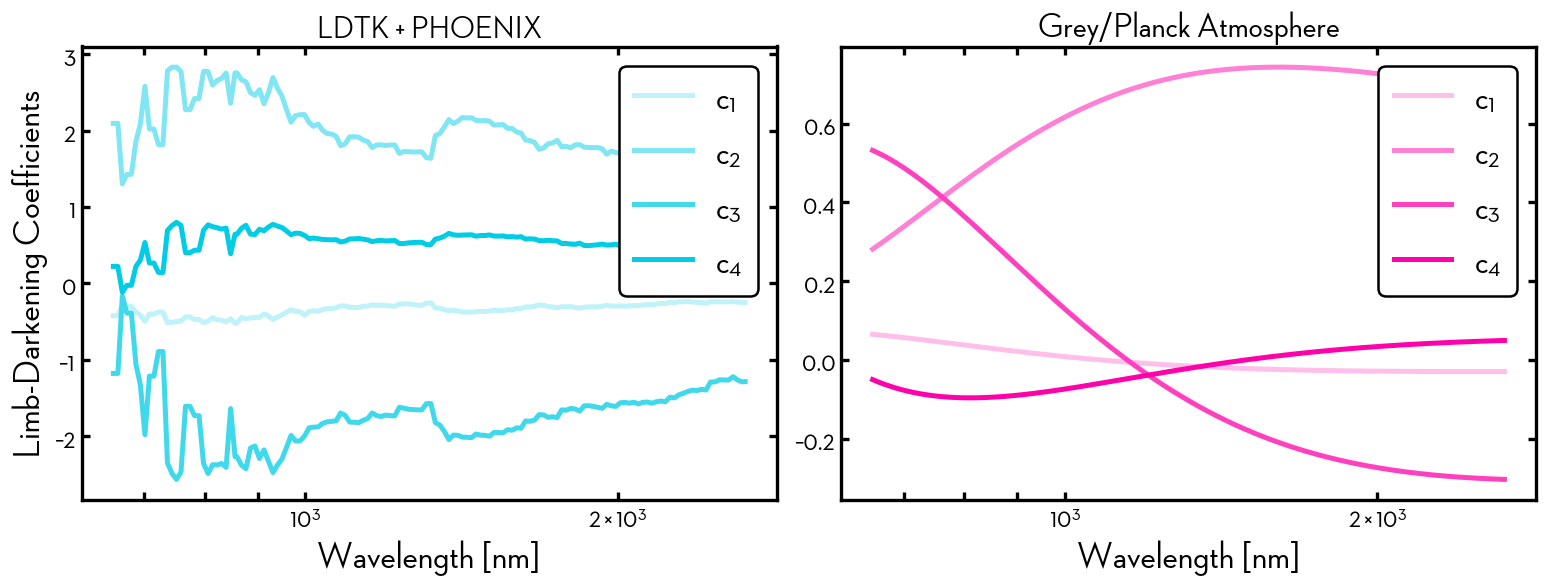

In [13]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib import rcParams
import os
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter, LogLocator
from matplotlib.colors import to_rgb
from matplotlib.lines import Line2D

plt.rcParams['axes.linewidth'] = 2

# Configurar cache da fonte (remover se necessário)
font_cache_dir = os.path.join(mpl.get_cachedir(), 'fontList.json')
if os.path.exists(font_cache_dir):
    os.remove(font_cache_dir)

# Definir o caminho para a fonte personalizada
diretorio_dados = r"C:\Users\vikto\OneDrive\PhD_Mackenzie\Small Radius Planets"
font_path = os.path.join(diretorio_dados, "Neutraface2Display-Medium.otf")
fm.fontManager.addfont(font_path)
neutra_face = fm.FontProperties(fname=font_path).get_name()

# Configurações globais de fonte
plt.rcParams['font.family']      = 'sans-serif'
plt.rcParams['font.sans-serif']  = [neutra_face]
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm']      = neutra_face
plt.rcParams['mathtext.it']      = f'{neutra_face}:italic'
plt.rcParams['mathtext.bf']      = f'{neutra_face}:bold'

# ======================================================================
# compare_ldc_phoenix_vs_grey.py
# ======================================================================
from __future__ import annotations

from ldtk_ldc import ldc_ldtk_for_channels

# ---------------------------------------------------------
# 1) Basic configuration
# ---------------------------------------------------------
MRT_PATH = "apjlad5afat2_mrt.txt"
R_MIN_CHAN_FLOOR = 300.0

TEFF = 3096.0   # LHS 1140
LOGG = 5.0
FEH  = 0.0

GREY_MU_TAU_ALPHA = 1.0
GREY_Q_EDD        = 2.0/3.0
GREY_NMU          = 101

APODIZE_TUKEY = True
TUKEY_ALPHA   = 0.80

_h = 6.62607015e-34
_c = 2.99792458e8
_k = 1.380649e-23
_EPS = 1e-15


def color_family(base_color, n=4):
    """Generate n shades from a base color (same style as the corner plot)."""
    base = np.array(to_rgb(base_color))
    colors = []
    alphas = np.linspace(0.25, 1.0, n)
    for a in alphas:
        c = (1.0 - a) * np.ones(3) + a * base
        colors.append(c)
    return colors


# ---------------------------------------------------------
# Legend helpers (use the same visual style as your text-box legend)
# ---------------------------------------------------------
def _style_box_legend(leg):
    frame = leg.get_frame()
    frame.set_edgecolor("black")
    frame.set_linewidth(1.5)
    frame.set_facecolor("white")
    frame.set_alpha(1.0)


def _add_c_coeff_legend(ax, colors, loc="upper right", fontsize=15):
    """
    Legenda para c1–c4 com mesma estética da caixa:
    borda preta, fundo branco, etc.
    """
    labels = [r"$c_1$", r"$c_2$", r"$c_3$", r"$c_4$"]
    handles = [Line2D([], [], color=c, lw=3) for c in colors]
    leg = ax.legend(
        handles, labels,
        frameon=True, fontsize=fontsize,
        handlelength=1.5, handletextpad=0.6, loc=loc
    )
    _style_box_legend(leg)
    return leg


# ---------------------------------------------------------
# MRT loader
# ---------------------------------------------------------
def load_mrt_centers_and_widths(path: str):
    lam, wid = [], []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if (not s) or s.startswith(("#", ";")):
                continue
            if s.lower().startswith(
                ("title", "table", "note", "column")
            ) or s.startswith("---"):
                continue
            parts = s.replace(",", " ").split()
            vals = []
            for tok in parts:
                try:
                    vals.append(float(tok))
                except Exception:
                    pass
            if len(vals) < 2:
                continue
            lam.append(vals[0])
            wid.append(vals[1])
    if not lam:
        raise RuntimeError(f"No numeric rows found in '{path}'.")
    lam = np.asarray(lam, float)
    wid = np.asarray(wid, float)
    wid = np.maximum(wid, lam / float(R_MIN_CHAN_FLOOR))
    order = np.argsort(lam)
    return lam[order], wid[order]


# ---------------------------------------------------------
# Grey atmosphere + Planck
# ---------------------------------------------------------
def planck_lambda_um(lam_um: np.ndarray, T: float) -> np.ndarray:
    lam_m = np.asarray(lam_um, float) * 1e-6
    lam_m = np.clip(lam_m, 1e-30, None)
    x = (_h * _c) / (_k * T) / lam_m
    x = np.clip(x, 1e-9, 700.0)
    ex = np.exp(x) - 1.0
    return (1.0 / lam_m**5) / np.clip(ex, 1e-30, None)


def tukey_window_segment(lam, lo, hi, alpha=0.6):
    lam = np.asarray(lam, float)
    L = hi - lo
    if not np.isfinite(L) or L <= 0:
        return np.zeros_like(lam)
    u = (lam - lo) / L
    a = float(np.clip(alpha, 0.0, 1.0))
    w = np.zeros_like(lam)
    left  = (u >= 0) & (u < a/2)
    right = (u <= 1) & (u > 1 - a/2)
    mid   = (u >= a/2) & (u <= 1 - a/2)
    w[left]  = 0.5 * (1 + np.cos(np.pi*(2*u[left]/a - 1)))
    w[right] = 0.5 * (1 + np.cos(np.pi*(2*u[right]/a - 2/a + 1)))
    w[mid]   = 1.0
    w[(u < 0) | (u > 1)] = 0.0
    s = float(np.trapz(w, lam)) or 1.0
    return w / s


def ldc_grey_planck(
    lambdaEff_um: np.ndarray,
    dx_low_um: np.ndarray,
    dx_high_um: np.ndarray,
    Teff: float,
    mu_tau_alpha: float = 1.0,
    q_edd: float = 2.0/3.0,
    nmu: int = 51,
    channel_window_kind: str = "tukey",
    channel_tukey_alpha: float = 0.7,
):
    lam_c = np.asarray(lambdaEff_um, float)
    dlo   = np.asarray(dx_low_um, float)
    dhi   = np.asarray(dx_high_um, float)
    n_ch  = lam_c.size

    mu = np.linspace(0.02, 1.0, int(max(9, nmu)))

    c1 = np.zeros(n_ch)
    c2 = np.zeros(n_ch)
    c3 = np.zeros(n_ch)
    c4 = np.zeros(n_ch)

    X = np.column_stack(
        [1 - mu**0.5, 1 - mu, 1 - mu**1.5, 1 - mu**2]
    )

    for i in range(n_ch):
        lo = float(lam_c[i] + dlo[i])
        hi = float(lam_c[i] + dhi[i])
        if not (np.isfinite(lo) and np.isfinite(hi) and hi > lo):
            continue

        nlam = 161
        lam = np.linspace(lo, hi, nlam)

        if channel_window_kind.lower().startswith("tukey"):
            W = tukey_window_segment(
                lam, lo, hi, alpha=channel_tukey_alpha
            )
        else:
            W = np.where(
                (lam >= lo) & (lam <= hi), 1.0, 0.0
            )
            sW = float(np.trapz(W, lam)) or 1.0
            W /= sW

        I_mu = np.empty_like(mu)
        for j, muj in enumerate(mu):
            tau = float(mu_tau_alpha) * float(muj)
            T_tau = float(Teff) * np.power(
                0.75 * (tau + q_edd), 0.25
            )
            Bl = planck_lambda_um(lam, T_tau)
            I_mu[j] = float(np.trapz(Bl * W, lam))

        I1 = max(I_mu[-1], _EPS)
        S = I_mu / I1
        y = 1.0 - S

        coef, *_ = np.linalg.lstsq(X, y, rcond=None)
        c1[i], c2[i], c3[i], c4[i] = coef

    return c1, c2, c3, c4


# ---------------------------------------------------------
# PHOENIX intensity grid via LDTK (no extra smoothing)
# ---------------------------------------------------------
def compute_ldc_ldtk_raw(
    lambdaEff_um: np.ndarray,
    dx_low_um: np.ndarray,
    dx_high_um: np.ndarray,
):
    """
    LDCs computed from the PHOENIX specific-intensity grid via LDTK,
    without any extra smoothing. This is your "PHOENIX intensity grid"
    version (no CSV, no throughput).
    """
    c1, c2, c3, c4 = ldc_ldtk_for_channels(
        lambdaEff_um=lambdaEff_um,
        dx_low_um=dx_low_um,
        dx_high_um=dx_high_um,
        teff=TEFF,
        logg=LOGG,
        feh=FEH,
        teff_unc=50.0,
        logg_unc=0.1,
        feh_unc=0.1,
        law="claret4",
        dataset="visir-lowres",
        throughput_csv=None,
        throughput_array=None,
        smooth_mode="none",
        R_smooth_lines=120.0,
        sigma_const_um=None,
        smooth_kind="none",
        tukey_alpha=None,
        R_fit_min=None,
        R_fit_min_blue=None,
        R_fit_min_red=None,
        R_fit_min_pivot_um=1.0,
        half_split=False,
        jitter_strategy="avg_kernel",
        jitter_n=1,
        jitter_spread=0.0,
        jitter_reduce="mean",
        aggregate="median",
        post_smooth_R=None,
        n_sub=1601,
        timeout_s=180.0,
        max_retries=8,
        verbose=True,
    )
    return c1, c2, c3, c4


# ---------------------------------------------------------
# Main
# ---------------------------------------------------------
def main():
    lambdaEff_um, width_um = load_mrt_centers_and_widths(MRT_PATH)
    dx_low_um  = -0.5 * width_um
    dx_high_um = +0.5 * width_um

    print("[PHX] Computing PHOENIX intensity-grid limb-darkening coefficients...")
    c1_ph, c2_ph, c3_ph, c4_ph = compute_ldc_ldtk_raw(
        lambdaEff_um, dx_low_um, dx_high_um
    )

    print("[GREY] Computing grey-atmosphere limb-darkening coefficients...")
    c1_gr, c2_gr, c3_gr, c4_gr = ldc_grey_planck(
        lambdaEff_um=lambdaEff_um,
        dx_low_um=dx_low_um,
        dx_high_um=dx_high_um,
        Teff=TEFF,
        mu_tau_alpha=GREY_MU_TAU_ALPHA,
        q_edd=GREY_Q_EDD,
        nmu=GREY_NMU,
        channel_window_kind=("tukey" if APODIZE_TUKEY else "rect"),
        channel_tukey_alpha=TUKEY_ALPHA,
    )

    lam_nm = lambdaEff_um * 1000.0

    colors_ph = color_family("#00cce6", n=4)
    colors_gr = color_family("#ff00aa", n=4)

    fig, (axL, axR) = plt.subplots(1, 2, figsize=(13, 5), dpi=120)

    for ax in (axL, axR):
        ax.tick_params(
            axis='both', which='both',
            direction='in', top=True, right=True,
            length=5, width=2, labelsize=17
        )

    # Left: PHOENIX intensity grid (via LDTK)
    for coeff, col in zip(
        (c1_ph, c2_ph, c3_ph, c4_ph),
        colors_ph
    ):
        axL.plot(lam_nm, coeff, color=col, linewidth=3.0)

    axL.set_xlabel("Wavelength [nm]", fontsize=23)
    axL.set_ylabel("Limb-Darkening Coefficients", fontsize=23)
    axL.set_title("LDTK + PHOENIX", fontsize=19)
    axL.set_xscale("log")
    _add_c_coeff_legend(axL, colors_ph, loc="upper right", fontsize=23)

    # Right: grey atmosphere
    for coeff, col in zip(
        (c1_gr, c2_gr, c3_gr, c4_gr),
        colors_gr
    ):
        axR.plot(lam_nm, coeff, color=col, linewidth=3.0)

    axR.set_xlabel("Wavelength [nm]", fontsize=23)
    axR.set_title("Grey/Planck Atmosphere", fontsize=21)
    axR.set_xscale("log")
    _add_c_coeff_legend(axR, colors_gr, loc="upper right", fontsize=23)

    fig.tight_layout()
    plt.savefig("Paper Figures\\LDCs.svg", format="svg")
    plt.show()


if __name__ == "__main__":
    main()
